# Imports

In [ ]:
!pip install kaggle
!pip install fastdtw

In [ ]:
import os
import ast
import glob
import torch
import random
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from shutil import copyfile
from scipy.stats import zscore
from google.colab import files
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans, DBSCAN
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler


In [ ]:
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bgu-i-cant-see-you-but-you-are-reading-a-book
with zipfile.ZipFile("/content/bgu-i-cant-see-you-but-you-are-reading-a-book.zip", "r") as zip_ref:
    zip_ref.extractall("i_cant_see")

# Metadata analysis

In [ ]:
df_metadata = pd.read_csv('/content/metadata.csv')

In [ ]:
unique_counts = df_metadata.nunique()
print(unique_counts)
print("-"*80)
print(df_metadata.info())

sample_id          74744
userid                21
sensor                 2
body_part              2
side                   2
sequence_length        3
dtype: int64
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74744 entries, 0 to 74743
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sample_id        74744 non-null  int64 
 1   userid           74744 non-null  object
 2   sensor           74744 non-null  object
 3   body_part        74744 non-null  object
 4   side             74744 non-null  object
 5   sequence_length  74744 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.4+ MB
None


In [ ]:
group_counts_users = df_metadata.groupby('userid')
group_counts_sensor = df_metadata.groupby('sensor')

group_counts_sequence_length = df_metadata.groupby('sequence_length')
print(group_counts_users.size())
print("-"*80)
print(group_counts_sensor.size())

In [ ]:
user_counts = {
    'user01': 3919, 'user02': 3369, 'user03': 3555, 'user04': 3388,
    'user05': 3320, 'user06': 3015, 'user07': 3379, 'user08': 3111,
    'user09': 10732, 'user10': 9238, 'user11': 9044, 'user12': 9156,
    'user13': 9014, 'user14': 52, 'user15': 92, 'user16': 42,
    'user17': 108, 'user18': 37, 'user19': 92, 'user20': 36,
    'user21': 45
}
sensor_counts = {'smartwatch': 52187, 'vicon': 22557}

# Users distribution

<ipython-input-9-238ab1351d00>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(user_counts.keys()), y=list(user_counts.values()), palette="hls")


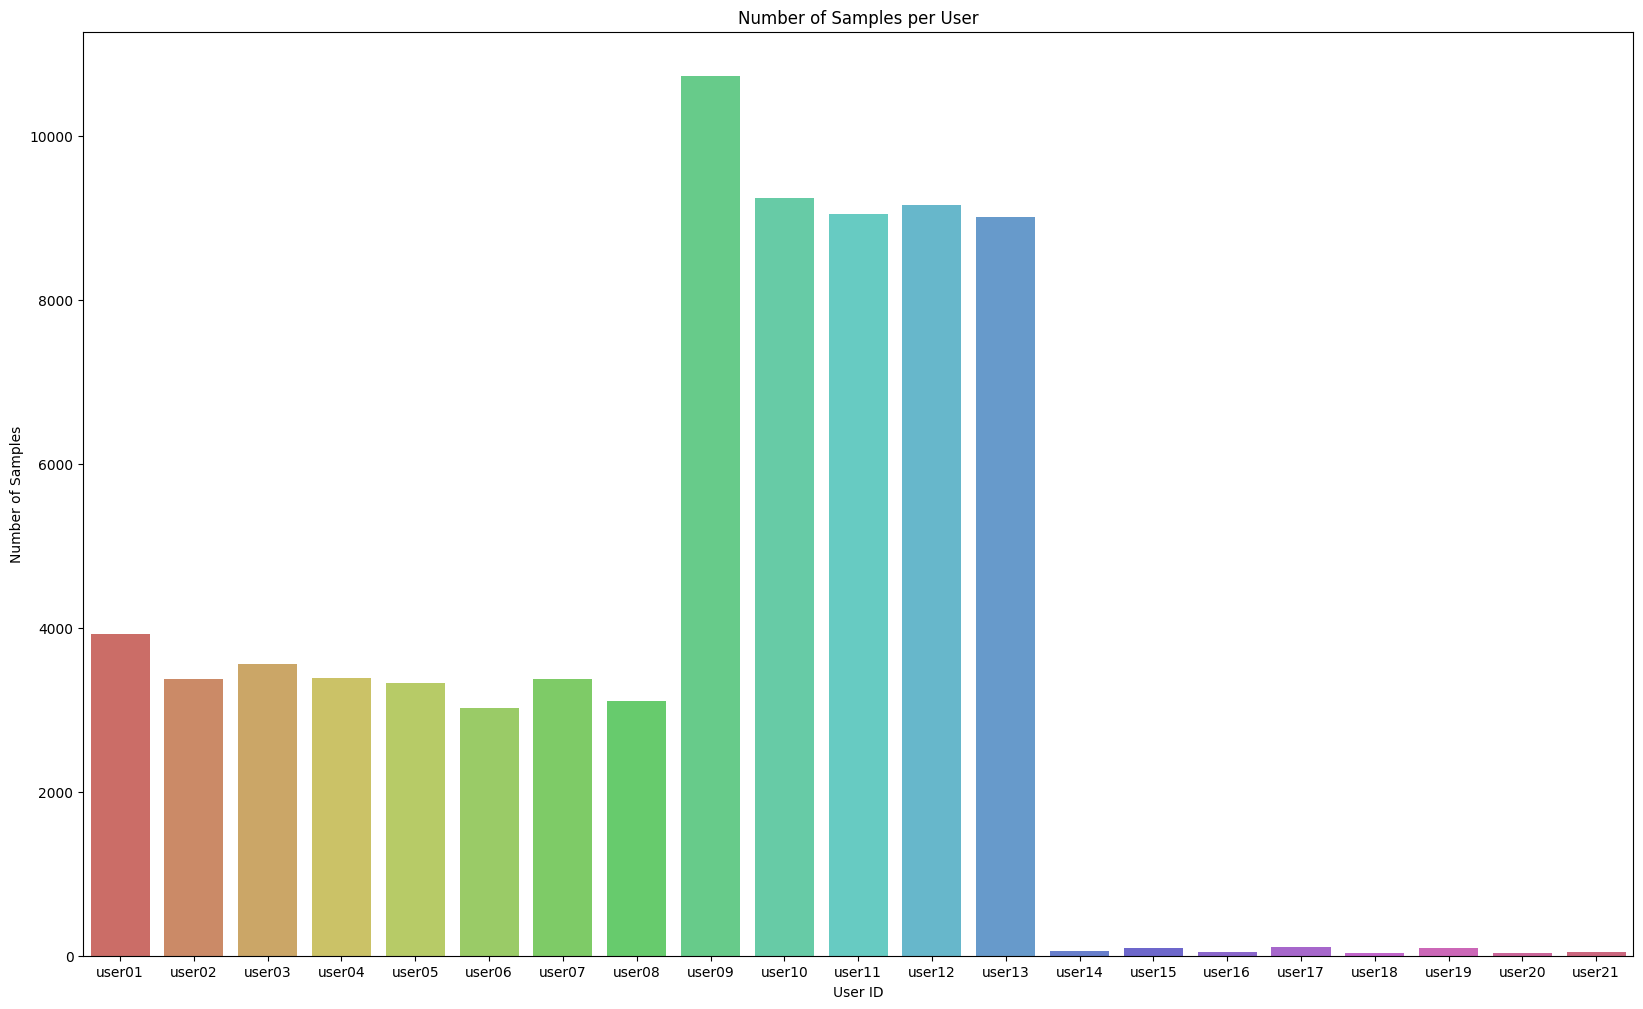

In [ ]:
plt.figure(figsize=(20, 12))
sns.barplot(x=list(user_counts.keys()), y=list(user_counts.values()), palette="hls")
plt.title("Number of Samples per User")
plt.ylabel("Number of Samples")
plt.xlabel("User ID")
plt.show()

# Sensor distribution

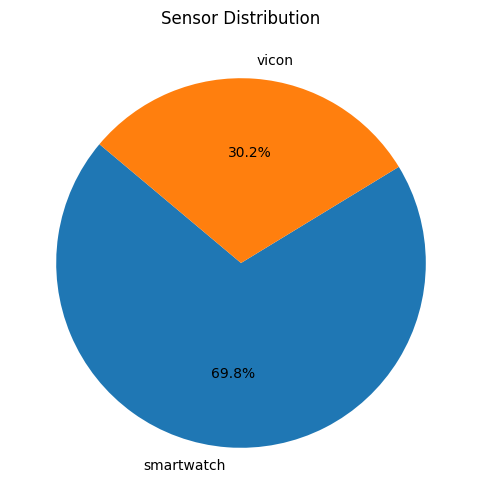

In [ ]:
# Visualize sensor distribution
plt.figure(figsize=(8, 6))
plt.pie(sensor_counts.values(), labels=sensor_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Sensor Distribution")
plt.show()


# Train analysis

In [ ]:
df_train = pd.read_csv('/content/i_cant_see/train.csv')

In [ ]:
unique_counts = df_train.nunique()
print(unique_counts)
print('-'*80)
print(df_train.info())

Unnamed: 0         50248
userid                 8
activity              18
sensor                 2
body_part              2
side                   2
id                 50248
sequence_length        3
dtype: int64
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50248 entries, 0 to 50247
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       50248 non-null  int64 
 1   userid           50248 non-null  object
 2   activity         50248 non-null  object
 3   sensor           50248 non-null  object
 4   body_part        50248 non-null  object
 5   side             50248 non-null  object
 6   id               50248 non-null  int64 
 7   sequence_length  50248 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 3.1+ MB
None


In [ ]:
group_counts_users = df_train.groupby('userid')
group_counts_sensor = df_train.groupby('sensor')
group_counts_activity = df_train.groupby('activity')
group_counts_sequence_length = df_train.groupby('sequence_length')
print(group_counts_users.size())
print('-'*80)
print(group_counts_sensor.size())
print('-'*80)
print(group_counts_activity.size())
print('-'*80)
print(group_counts_sequence_length.size())

In [ ]:
# Example data (replace with your actual DataFrame)
user_counts = {'user01': 7387, 'user02': 6102, 'user03': 6492, 'user04': 6348,
               'user05': 6262, 'user06': 5571, 'user07': 6331, 'user08': 5755}
sensor_counts = {'smartwatch': 36186, 'vicon': 14062}
activity_counts = {
    'brushing_teeth': 1435, 'idle': 2675, 'preparing_sandwich': 2242,
    'reading_book': 2508, 'stairs_down': 1155, 'stairs_up': 1256,
    'typing': 1199, 'using_phone': 4313, 'using_remote_control': 2552,
    'walking_freely': 4578, 'walking_holding_a_tray': 4441,
    'walking_with_handbag': 4510, 'walking_with_hands_in_pockets': 4243,
    'walking_with_object_underarm': 4412, 'washing_face_and_hands': 2490,
    'washing_mug': 2504, 'washing_plate': 2502, 'writing': 1233
}

# Users distribution

<ipython-input-16-c8463a3f1595>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(user_counts.keys()), y=list(user_counts.values()), palette="hls")


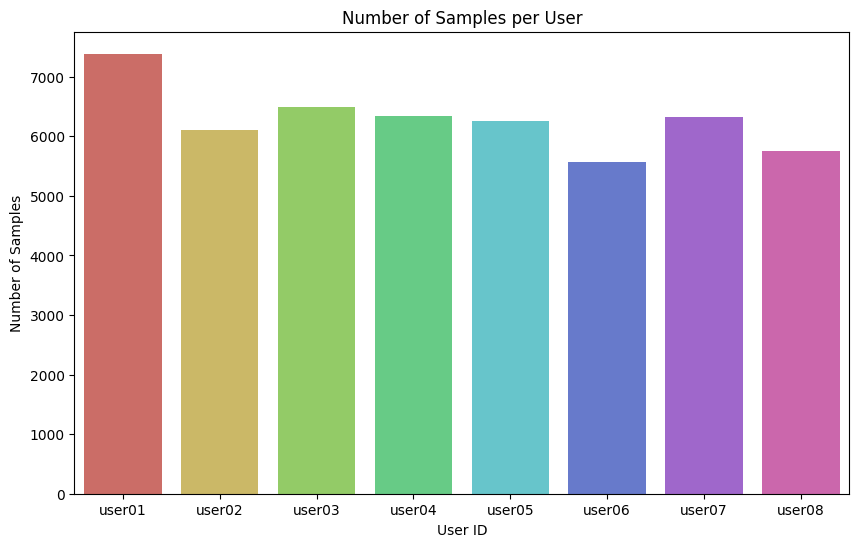

In [ ]:
# Visualize user contributions
plt.figure(figsize=(10, 6))
sns.barplot(x=list(user_counts.keys()), y=list(user_counts.values()), palette="hls")
plt.title("Number of Samples per User")
plt.ylabel("Number of Samples")
plt.xlabel("User ID")
plt.show()

# Sensor distribution

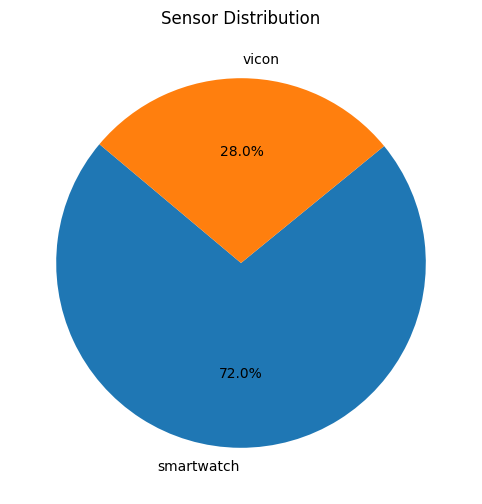

In [ ]:
# Visualize sensor distribution
plt.figure(figsize=(8, 6))
plt.pie(sensor_counts.values(), labels=sensor_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Sensor Distribution")
plt.show()

# Activity distribution

<ipython-input-18-d70a7560431b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(activity_counts.keys()), y=list(activity_counts.values()), palette="hls")


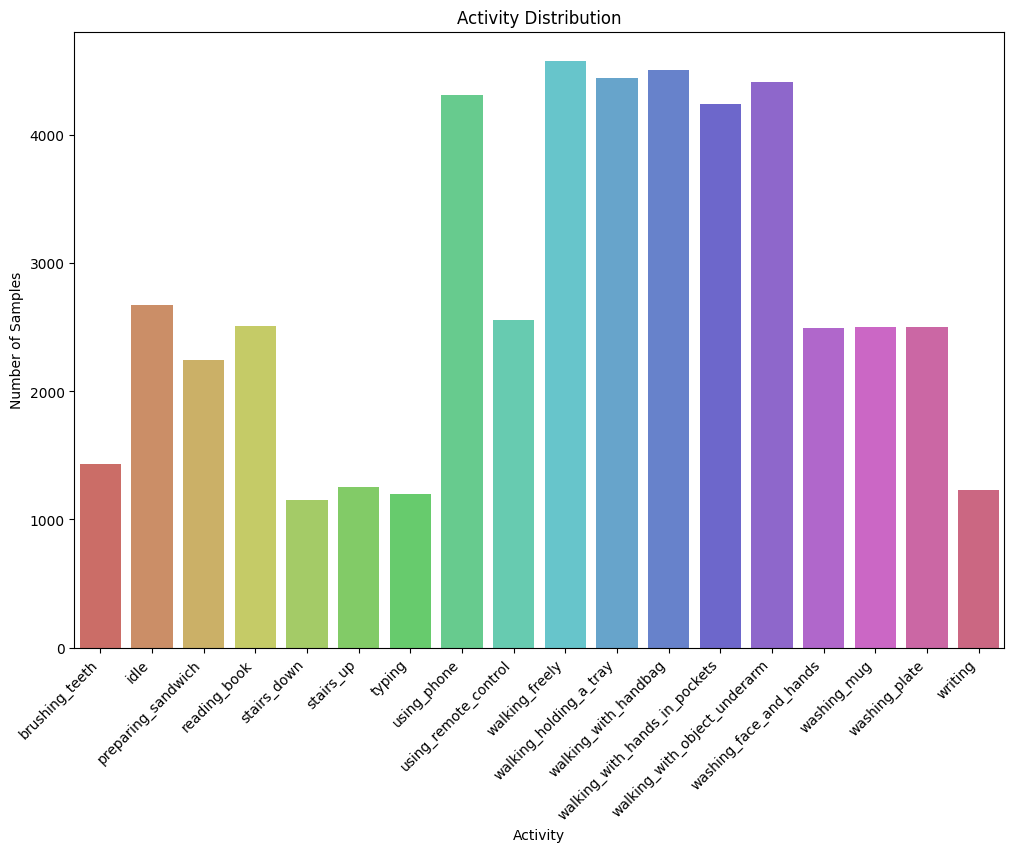

In [ ]:
# Visualize activity distribution
plt.figure(figsize=(12, 8))
sns.barplot(x=list(activity_counts.keys()), y=list(activity_counts.values()), palette="hls")
plt.xticks(rotation=45, ha='right')
plt.title("Activity Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Activity")
plt.show()


# Sensor and activity distribution

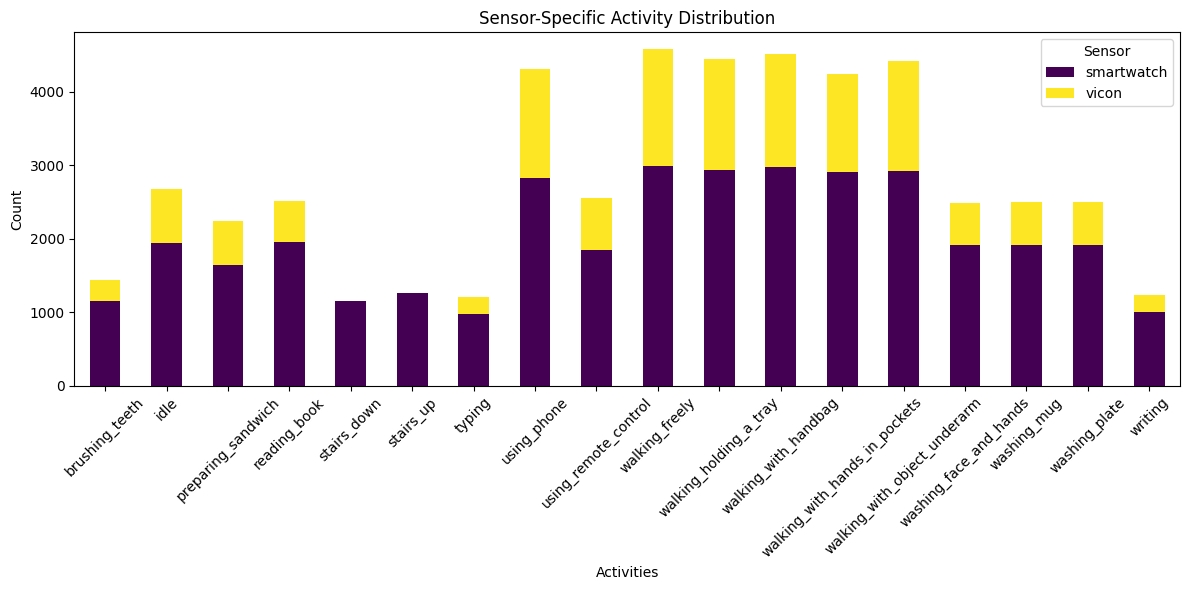

In [ ]:
sensor_activity_counts = df_train.groupby(['sensor', 'activity']).size().unstack().fillna(0)
sensor_activity_counts.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Sensor-Specific Activity Distribution')
plt.xlabel('Activities')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sensor')
plt.tight_layout()
plt.show()


## Columes
* userid- participant ID total 8
* acticity - the actions we are trying to predict total 18:
'stairs_up','walking_with_hands_in_pockets', 'walking_freely',
'using_phone', 'reading_book', 'idle',
'walking_with_object_underarm', 'washing_mug',
'walking_holding_a_tray', 'washing_face_and_hands',
'walking_with_handbag', 'washing_plate', 'using_remote_control',
'typing', 'preparing_sandwich', 'writing', 'stairs_down',
'brushing_teeth']
* sensor - the type of sensor we received the information from, there are two types smartwatch and vicon
* body_part - part of the body on which the sensor was placed (hand or foot)
* side - the side on which the sensor was placed (right or left)
* id - the identifier
* sequence_length - the amount of data collected from the sensor

## Explore sensor types column

# Smart Watch

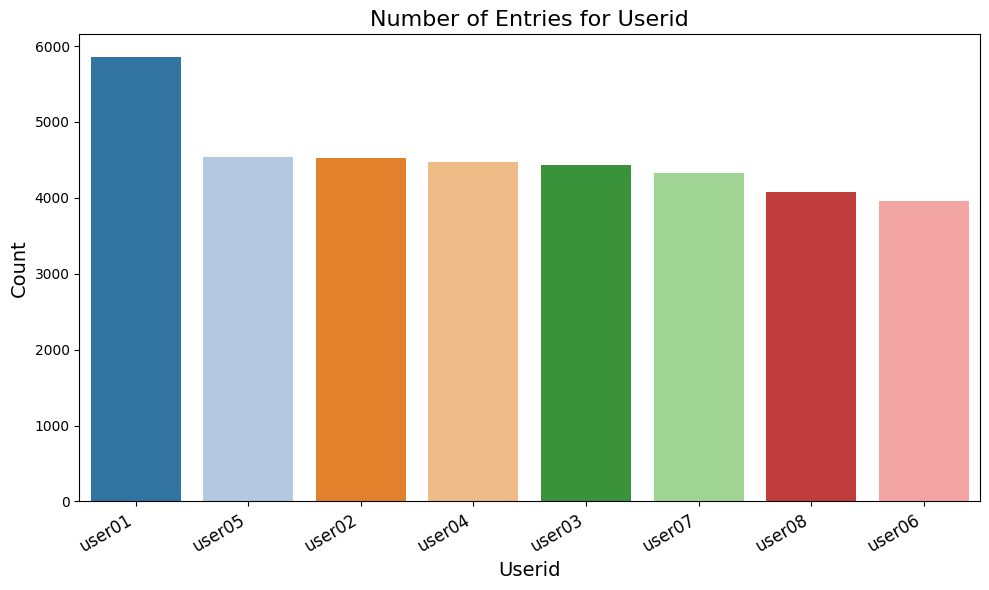

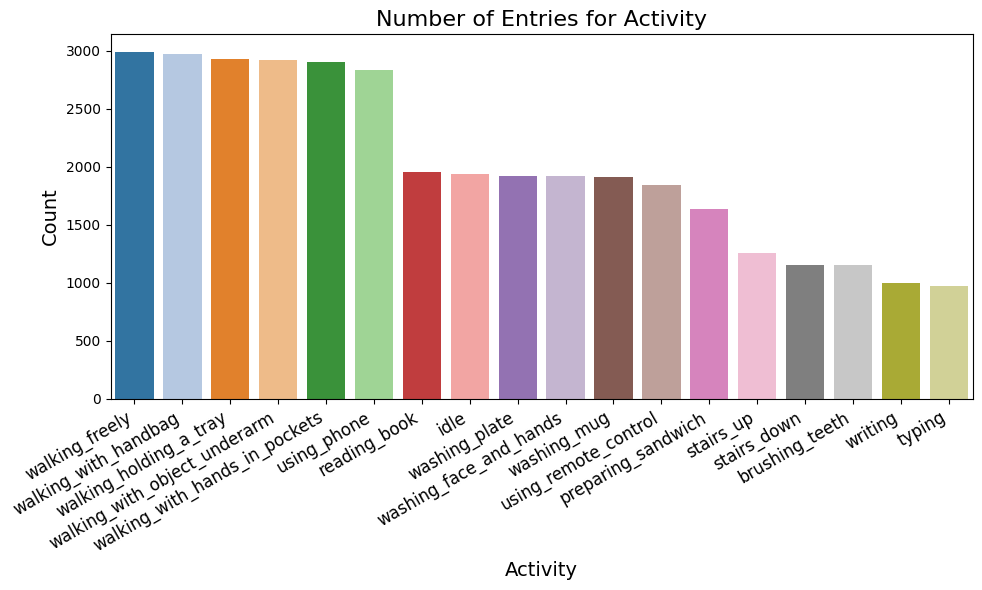

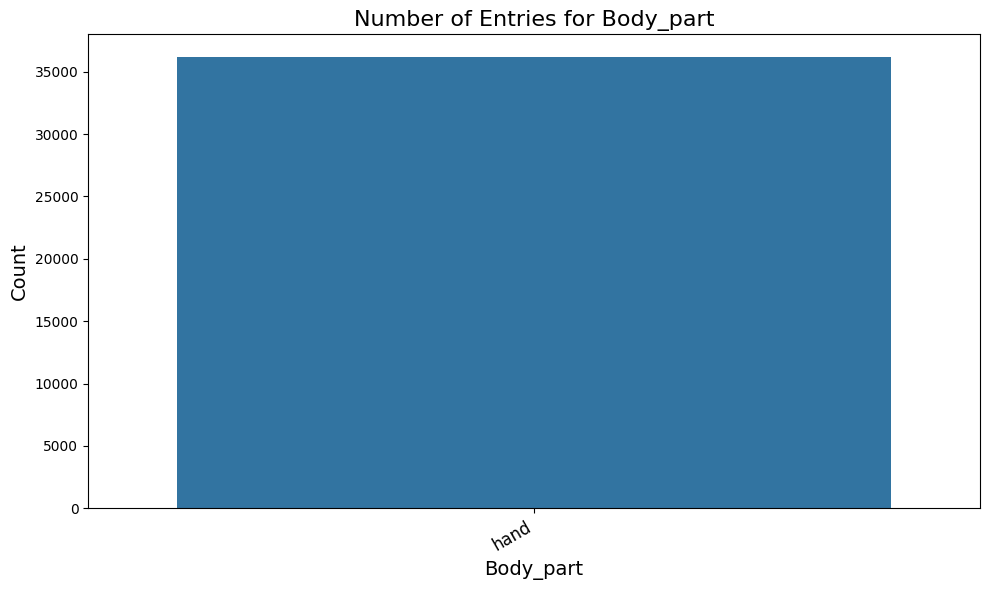

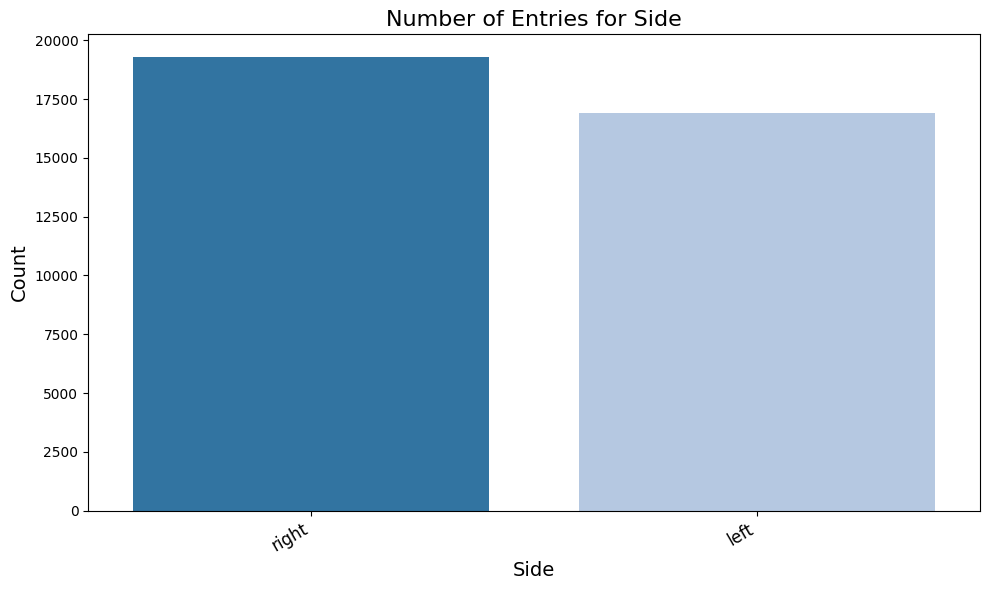

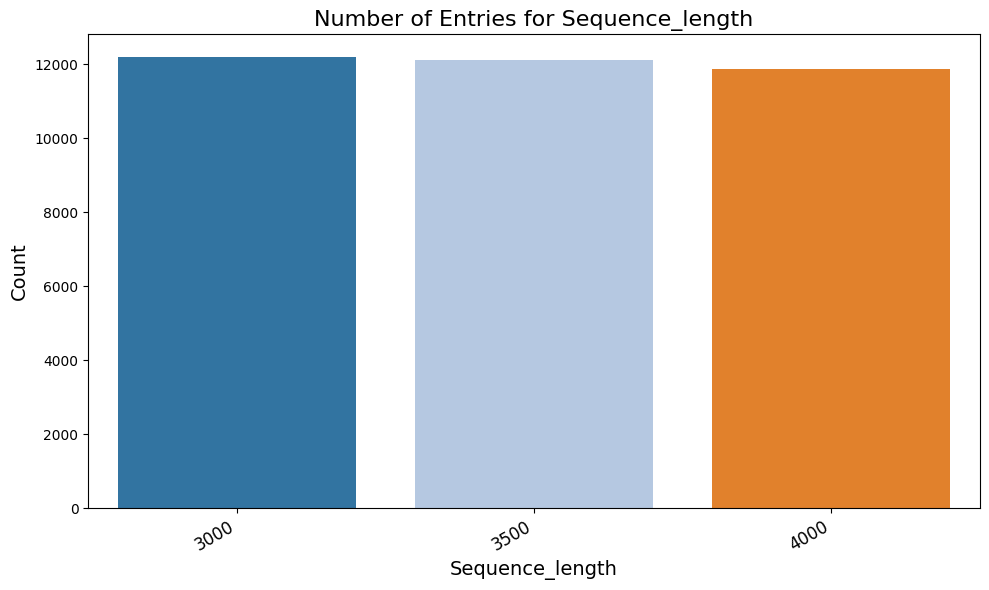

In [ ]:
sensor_dict = {sensor: df_train[df_train['sensor'] == sensor] for sensor in df_train['sensor'].unique()}

columns_to_plot = ['userid','activity', 'body_part', 'side', 'sequence_length']

watsmart = sensor_dict['smartwatch']
vicon = sensor_dict['vicon']

for column in columns_to_plot:
    value_counts = watsmart[column].value_counts()
    dynamic_colors = sns.color_palette("tab20", len(value_counts))


    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values,hue=value_counts.index,dodge=False,legend=False, palette=dynamic_colors)

    plt.title(f'Number of Entries for {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)

    plt.xticks(rotation=30, fontsize=12, ha='right')
    plt.tight_layout()
    plt.show()


# Vicon

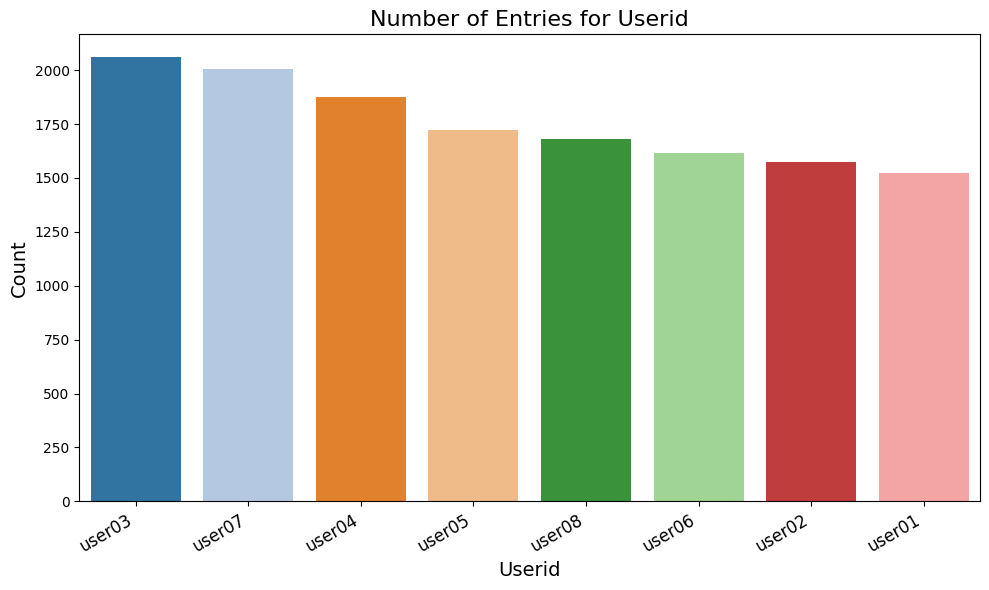

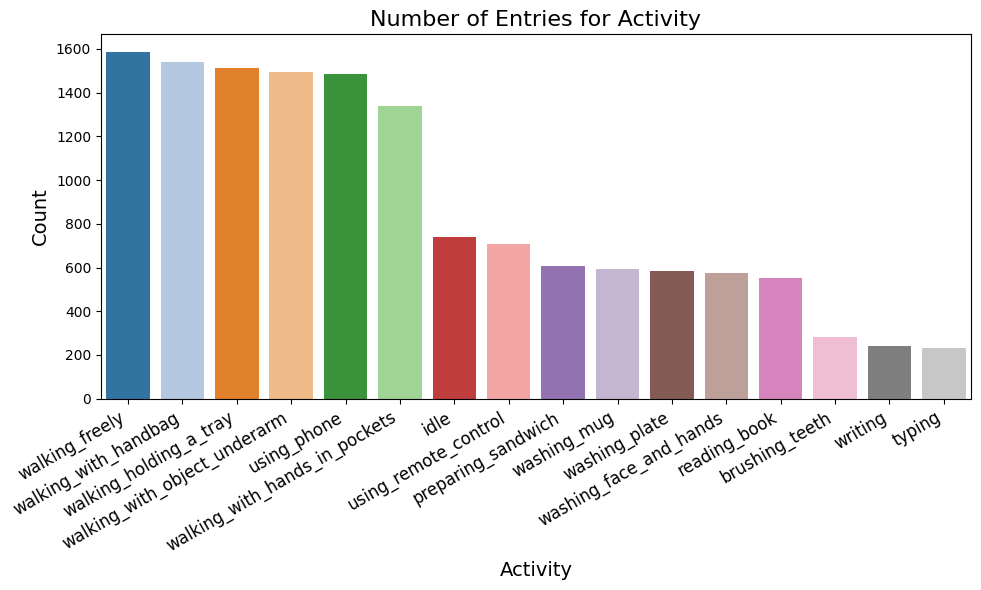

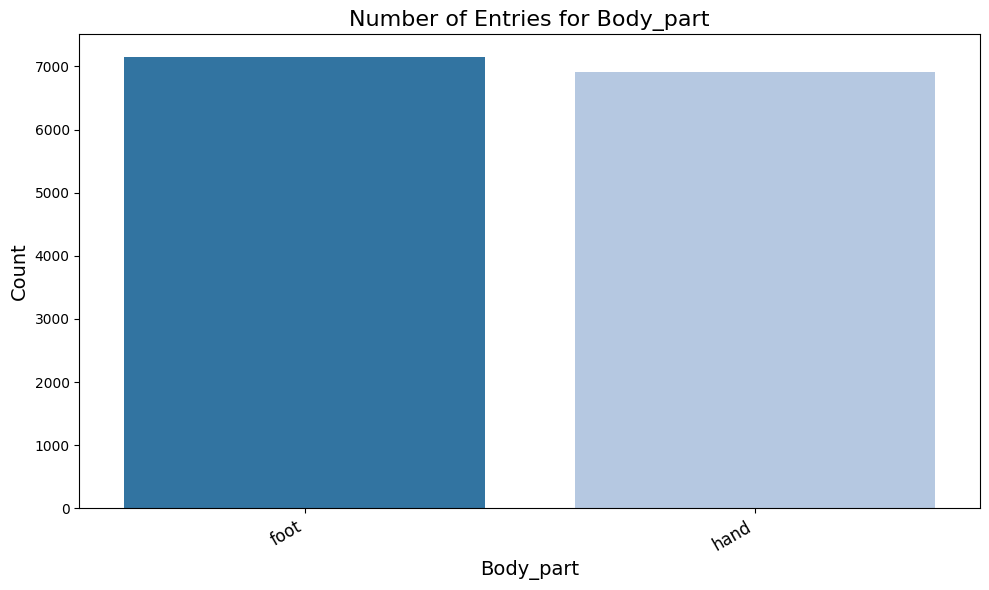

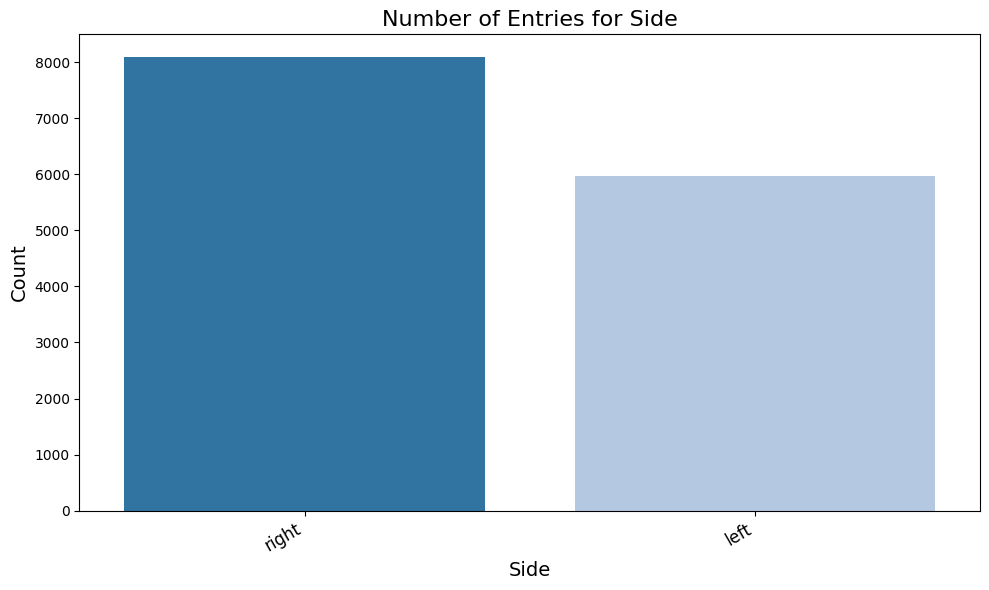

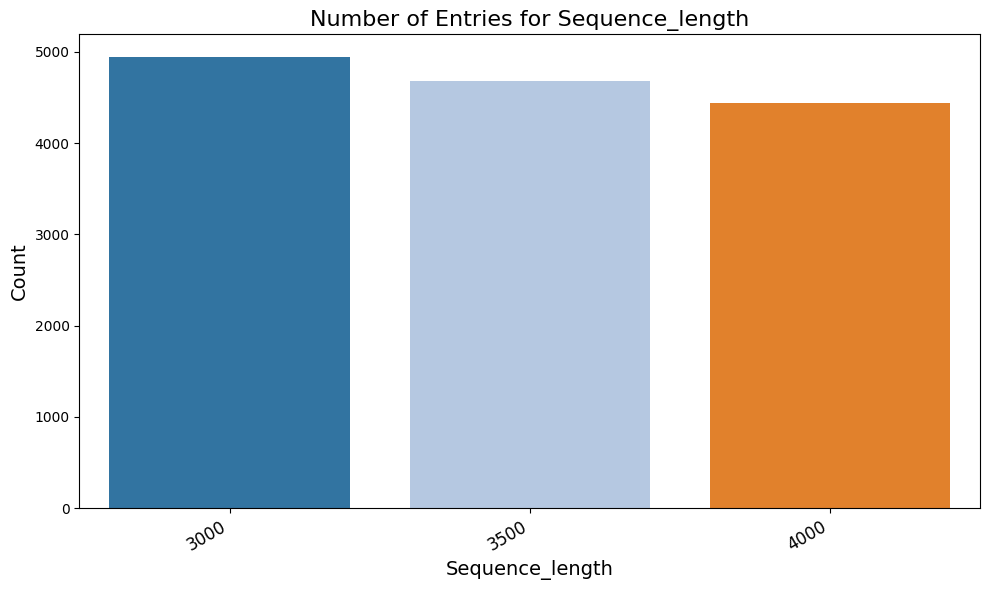

In [ ]:
for column in columns_to_plot:
    value_counts = vicon[column].value_counts()
    dynamic_colors = sns.color_palette("tab20", len(value_counts))


    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values,hue=value_counts.index,dodge=False,legend=False, palette=dynamic_colors)

    plt.title(f'Number of Entries for {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)

    plt.xticks(rotation=30, fontsize=12, ha='right')
    plt.tight_layout()
    plt.show()

# Explore the users column 1-8

In [ ]:
userid_dict = {userid: df_train[df_train['userid'] == userid] for userid in df_train['userid'].unique()}

columns_to_plot = ['sensor','activity', 'body_part', 'side', 'sequence_length']

In [ ]:
def plot_distributions(df):
  for column in columns_to_plot:
      value_counts = df[column].value_counts()
      dynamic_colors = sns.color_palette("tab20", len(value_counts))


      plt.figure(figsize=(10, 6))
      sns.barplot(x=value_counts.index, y=value_counts.values,hue=value_counts.index,dodge=False,legend=False, palette=dynamic_colors)

      plt.title(f'Number of Entries for {column.capitalize()}', fontsize=16)
      plt.xlabel(column.capitalize(), fontsize=14)
      plt.ylabel('Count', fontsize=14)

      plt.xticks(rotation=30, fontsize=12, ha='right')
      plt.tight_layout()
      plt.show()

for i in range(1,8):
  print('-'*60,f'user0{i}','-'*60)
  plot_distributions(userid_dict[f'user0{i}'])

# Explore the activity column

In [ ]:
activity_dict = {userid: df_train[df_train['activity'] == userid] for userid in df_train['activity'].unique()}

columns_to_plot = ['sensor','userid', 'body_part', 'side', 'sequence_length']

In [ ]:
def plot_distributions(df):
  for column in columns_to_plot:
      value_counts = df[column].value_counts()
      dynamic_colors = sns.color_palette("tab20", len(value_counts))


      plt.figure(figsize=(10, 6))
      sns.barplot(x=value_counts.index, y=value_counts.values,hue=value_counts.index,dodge=False,legend=False, palette=dynamic_colors)

      plt.title(f'Number of Entries for {column.capitalize()}', fontsize=16)
      plt.xlabel(column.capitalize(), fontsize=14)
      plt.ylabel('Count', fontsize=14)

      plt.xticks(rotation=30, fontsize=12, ha='right')
      plt.tight_layout()
      plt.show()


for i in activity_dict.keys():
  print('-'*60,i,'-'*60)
  plot_distributions(activity_dict[i])

#Modeling the data by dictionaries

##Investigating and modeling
user and sensor actions to obtain a template for predictions

#Dismantling
* user -> actviti
* user -> actviti-> sensor
* user -> actviti-> sensor -> body_part
* user -> actviti -> sensor -> body_part -> side
* user -> actviti -> sensor -> body_part -> side ->sequence_length

In [ ]:
#user -> actviti
user_activity_dict = {
    (userid, activity): df_train[(df_train['userid'] == userid) & (df_train['activity'] == activity)]
    for userid in df_train['userid'].unique()
    for activity in df_train[df_train['userid'] == userid]['activity'].unique()
}

#user -> actviti-> sensor
user_activity_sensor_dict = {
    (userid, activity, sensor): df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]
    for userid in df_train['userid'].unique()
    for activity in df_train[df_train['userid'] == userid]['activity'].unique()
    for sensor in df_train[(df_train['userid'] == userid) & (df_train['activity'] == activity)]['sensor'].unique()
}



#user -> actviti-> sensor -> body_part
user_activity_sensor_bodypart_dict = {
    (userid, activity, sensor, body_part): df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]
    for userid in df_train['userid'].unique()
    for activity in df_train[df_train['userid'] == userid]['activity'].unique()
    for sensor in df_train[(df_train['userid'] == userid) & (df_train['activity'] == activity)]['sensor'].unique()
    for body_part in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]['body_part'].unique()
}


#user -> actviti -> sensor -> body_part -> side
user_activity_sensor_bodypart_side_dict = {
    (userid, activity, sensor, body_part, side): df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part) &
        (df_train['side'] == side)
    ]
    for userid in df_train['userid'].unique()
    for activity in df_train[df_train['userid'] == userid]['activity'].unique()
    for sensor in df_train[(df_train['userid'] == userid) & (df_train['activity'] == activity)]['sensor'].unique()
    for body_part in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]['body_part'].unique()
    for side in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]['side'].unique()
}

#user -> actviti -> sensor -> body_part -> side ->sequence_length
user_activity_sensor_bodypart_side_sequence_length_dict = {
    (userid, activity, sensor, body_part, side, sequence_length): df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part) &
        (df_train['side'] == side) &
        (df_train['sequence_length'] == sequence_length)
    ]
    for userid in df_train['userid'].unique()
    for activity in df_train[df_train['userid'] == userid]['activity'].unique()
    for sensor in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity)
    ]['sensor'].unique()
    for body_part in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]['body_part'].unique()
    for side in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]['side'].unique()
    for sequence_length in df_train[
        (df_train['userid'] == userid) &
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part) &
        (df_train['side'] == side)
    ]['sequence_length'].unique()
}

* activity -> sensor
* activity -> sensor -> body_part
* activity -> sensor -> body_part ->side

In [ ]:
activity_sensor_dict = {
    (activity, sensor): df_train[
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]
    for activity in df_train['activity'].unique()
    for sensor in df_train[df_train['activity'] == activity]['sensor'].unique()
}

#activity -> sensor -> body_part
activity_sensor_bodypart_dict = {
    (activity, sensor, body_part): df_train[
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]
    for activity in df_train['activity'].unique()
    for sensor in df_train[df_train['activity'] == activity]['sensor'].unique()
    for body_part in df_train[
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]['body_part'].unique()
}


# activity -> sensor -> body_part ->side
activity_sensor_bodypart_side_dict = {
    (activity, sensor, body_part, side): df_train[
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part) &
        (df_train['side'] == side)
    ]
    for activity in df_train['activity'].unique()
    for sensor in df_train[df_train['activity'] == activity]['sensor'].unique()
    for body_part in df_train[
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor)
    ]['body_part'].unique()
    for side in df_train[
        (df_train['activity'] == activity) &
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]['side'].unique()
}

* sensor -> body_part
* sensor -> body_part ->side

In [ ]:
# sensor -> body_part
sensor_bodypart_dict = {
    (sensor, body_part): df_train[
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]
    for sensor in df_train['sensor'].unique()
    for body_part in df_train[df_train['sensor'] == sensor]['body_part'].unique()
}

# sensor -> body_part ->side
sensor_bodypart_side_dict = {
    (sensor, body_part, side): df_train[
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part) &
        (df_train['side'] == side)
    ]
    for sensor in df_train['sensor'].unique()
    for body_part in df_train[df_train['sensor'] == sensor]['body_part'].unique()
    for side in df_train[
        (df_train['sensor'] == sensor) &
        (df_train['body_part'] == body_part)
    ]['side'].unique()
}

In [ ]:
len(activity_sensor_bodypart_side_dict)

98

#Tablet analysis from two types of sensors

#Smartwatch Tablets come in the following form:
##Differences Between Measurements:

1. Gyroscope [rad/s]:
* What it measures:
 A gyroscope measures the angular velocity of an object around specific axes, usually the X, Y, and Z axes.
* Units:
 Measured in radians per second (rad/s), representing the rotational angle change over time.
* Common Uses:
 * Tracking rotational motion (e.g., in smartphones, drones, and smartwatches).
 * Detecting orientation and angular changes.
 * Enhancing accuracy in GPS and movement tracking.
* Example Application:
 Games or virtual reality applications that monitor device orientation and movement.
2. Acceleration [m/s²]:
 * What it measures:
  An accelerometer measures linear acceleration acting on an object, including acceleration caused by gravity.
 * Units:
  Measured in meters per second squared (m/s²), representing changes in velocity over time.
 * Common Uses:
   * Detecting motion (e.g., walking, running, or falls).
   * Measuring gravitational force (e.g., tilt angle detection in devices).
   * Tracking linear movements such as vehicle acceleration.
 * Example Application:
   * Counting steps in smartwatches.
   * Monitoring vibrations in heavy machinery.
3. Magnetometer [μT]:
 * What it measures:
 A magnetometer measures the strength of the magnetic field in the surrounding environment, typically on X, Y, and Z axes.
* Units:
 Measured in microteslas (μT), a unit of magnetic field strength.
* Common Uses:
 * Detecting direction (used as a digital compass).
 * Identifying magnetic disturbances in the environment.
 * Monitoring magnetic fields for geophysical applications.
* Example Application:
 * Digital compasses in smart devices.
 * Detecting metals or magnetic fields in industrial settings.

#vicon
coming with x[m] y[m] z[m]

# Functions for analysis

In [ ]:
directory_path = '/content/i_cant_see/unlabeled/unlabeled/'

def read_and_combine_data_from_dict(dicts, directory_path):
    all_data = []
    for idx, row in dicts.iterrows():
        file_id = row['id']
        file_name = f"{file_id}.csv"
        file_path = os.path.join(directory_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['id'] = file_id
            all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

def plot_distributions(df):
    plt.figure(figsize=(15, 6))
    if len(df.columns) == 4:
      sns.histplot(df['x [m]'], kde=True, color='blue', label='X', stat='density')
      sns.histplot(df['y [m]'], kde=True, color='green', label='Y', stat='density')
      sns.histplot(df['z [m]'], kde=True, color='red', label='Z', stat='density')

      plt.title("Distribution of x, y, z for all sensor data")
      plt.legend()
      plt.show()
    else:
      list_df = split_by_measurement_type(df)
      for i in list_df.keys():
        df = list_df[i]
        print('-'*20,i,'-'*20)
        sns.histplot(df['x'], kde=True, color='blue', label='X', stat='density')
        sns.histplot(df['y'], kde=True, color='green', label='Y', stat='density')
        sns.histplot(df['z'], kde=True, color='red', label='Z', stat='density')

        plt.title("Distribution of x, y, z for all sensor data")
        plt.legend()
        plt.show()



def plot_3d_distribution(df):
    try:
        if len(df.columns) == 4:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(df['x [m]'], df['y [m]'], df['z [m]'], c=df['z [m]'], cmap='viridis', s=10)
            ax.set_xlabel('X Axis')
            ax.set_ylabel('Y Axis')
            ax.set_zlabel('Z Axis')
            ax.set_title("3D Distribution of X, Y, Z for all sensor data")
            plt.show()
        else:
            list_df = split_by_measurement_type(df)
            for i, sub_df in list_df.items():
                print(f"Processing {i}:")
                print('-' * 20)

                # Create a new figure for each subset
                fig = plt.figure(figsize=(10, 8))
                ax = fig.add_subplot(111, projection='3d')

                # Ensure the required columns exist
                if {'x', 'y', 'z'}.issubset(sub_df.columns):
                    ax.scatter(sub_df['x'], sub_df['y'], sub_df['z'], c=sub_df['z'], cmap='viridis', s=10)
                    ax.set_xlabel('X Axis')
                    ax.set_ylabel('Y Axis')
                    ax.set_zlabel('Z Axis')
                    ax.set_title(f"3D Distribution for {i}")
                    plt.show()
                else:
                    print(f"Skipping {i}: Missing required columns (x, y, z).")
    except Exception as e:
        print(f"An error occurred: {e}")

def plot_sensor_data(df):
    try:
        plt.figure(figsize=(12, 6))
        if len(df.columns) == 3:
          plt.plot(df['x [m]'], label='X', color='blue')
          plt.plot(df['y [m]'], label='Y', color='green')
          plt.plot(df['z [m]'], label='Z', color='red')
          plt.title('Sensor Data (X, Y, Z)')
          plt.xlabel('Time')
          plt.ylabel('Value')
          plt.legend()
          plt.show()
        else:
          list_df = split_by_measurement_type(df)
          for i in list_df.keys():
            df = list_df[i]
            print('-'*20,i,'-'*2)
            plt.plot(df['x'], label='X', color='blue')
            plt.plot(df['y'], label='Y', color='green')
            plt.plot(df['z'], label='Z', color='red')

            plt.title('Sensor Data (X, Y, Z)')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Error reading {file_path}: {e}")

def split_by_measurement_type(df):
    measurement_types = df['measurement type'].unique()

    measurement_dict = {measurement: df[df['measurement type'] == measurement] for measurement in measurement_types}

    return measurement_dict



def calculate_circular_statistics(df, measurement_type):
    """
    Calculate circular statistics such as radius and angular changes.
    """
    subset = df[df['measurement type'] == measurement_type]

    # Compute radius
    subset['radius'] = np.sqrt(subset['x']**2 + subset['y']**2 + subset['z']**2)

    # Compute angular change (Δθ)
    subset['theta'] = np.arctan2(subset['y'], subset['x'])
    subset['delta_theta'] = subset['theta'].diff()

    circular_stats = {
        'mean_radius': subset['radius'].mean(),
        'std_radius': subset['radius'].std(),
        'variance_radius': subset['radius'].var(),
        'mean_angular_change': subset['delta_theta'].mean(),
        'std_angular_change': subset['delta_theta'].std(),
        'max_angular_change': subset['delta_theta'].max(),
        'min_angular_change': subset['delta_theta'].min()
    }

    return circular_stats

def generate_statistics(df):
    """
    Generate statistics for sensor data including circular statistics.
    """
    statistics = {}
    if len(df.columns) == 5:
        list_df = split_by_measurement_type(df)
        for i in list_df.keys():
            columns = ['x', 'y', 'z']
            df = list_df[i]

            # Basic statistics
            for col in columns:
                statistics[(col, i)] = {
                    'Mean': np.mean(df[col]),
                    'Standard Deviation': np.std(df[col]),
                    'Maximum': np.max(df[col]),
                    'Minimum': np.min(df[col]),
                    'Median': np.median(df[col]),
                    'Range': np.max(df[col]) - np.min(df[col]),
                    'Variance': np.var(df[col]),
                    'Unique Values': df[col].nunique(),
                    'Axis': col,
                    'Measurement_Type': i
                }

    else:
        columns = ['x [m]', 'y [m]', 'z [m]']
        for col in columns:
            statistics[col] = {
                'Mean': np.mean(df[col]),
                'Standard Deviation': np.std(df[col]),
                'Maximum': np.max(df[col]),
                'Minimum': np.min(df[col]),
                'Median': np.median(df[col]),
                'Range': np.max(df[col]) - np.min(df[col]),
                'Variance': np.var(df[col]),
                'Unique Values': df[col].nunique(),
                'Axis': col.split()[0],
                'Measurement_Type': 'vicon'
            }


    stats_df = pd.DataFrame(statistics).T
    stats_df.index.name = 'Column'
    return stats_df


def generate_statistics_table(user_activity_sensor_dict, key, directory_path,user_range=range(1, 8)):

    df_stas = pd.DataFrame(columns=['Column', 'Mean', 'Standard Deviation', 'Maximum', 'Minimum', 'Median', 'Range', 'Variance', 'Unique Values', 'Axis','Measurement_Type'])
    for i in user_range:
        updated_key = list(key)
        updated_key[0] = f'user0{i}'
        updated_key = tuple(updated_key)

        print(f"Processing {updated_key}")

        try:
            user_data = user_activity_sensor_dict[updated_key]
            combined_df = read_and_combine_data_from_dict(user_data, directory_path)
            stats = generate_statistics(combined_df)

            if isinstance(stats, pd.DataFrame):
                stats['Column'] = str(updated_key)
                df_stas = pd.concat([df_stas, stats], ignore_index=True)
            else:
                new_row = {
                    'Column': str(updated_key),
                    'Mean': stats['mean'],
                    'Standard Deviation': stats['std'],
                    'Maximum': stats['max'],
                    'Minimum': stats['min'],
                    'Median': stats['median'],
                    'Range': stats['range'],
                    'Variance': stats['variance'],
                    'Unique Values': stats['unique_values'],
                    'Axis': stats['axis'],'Measurement_Type':stats['Measurement_Type']
                }
                df_stas = df_stas.append(new_row, ignore_index=True)

        except KeyError:
            print(f"Key {key} not found. Skipping to the next user.")

    return df_stas


##Finding Right-Left Body Part Combinations in a Dictionary:

In [ ]:
right_left_combinations = []

for key1 in user_activity_sensor_bodypart_side_dict.keys():
    for key2 in user_activity_sensor_bodypart_side_dict.keys():
        if key1 != key2 and key1[:-1] == key2[:-1] and {key1[-1], key2[-1]} == {'right', 'left'}:
            right_left_combinations.append((key1, key2))

right_left_combinations = list(set(right_left_combinations))

In [ ]:
print(len(right_left_combinations))

# Count combinations options

In [ ]:
result_table = pd.DataFrame(columns=['Combination', 'Count'])

for i in activity_sensor_bodypart_side_dict.keys():
    count = len(activity_sensor_bodypart_side_dict[i])
    result_table = pd.concat([result_table, pd.DataFrame([{'Combination': i, 'Count': count}])], ignore_index=True)

In [ ]:
result_table

,Combination,Count
0,"(stairs_up, smartwatch, hand, right)",1256
1,"(walking_with_hands_in_pockets, smartwatch, ha...",1488
2,"(walking_with_hands_in_pockets, smartwatch, ha...",1416
3,"(walking_with_hands_in_pockets, vicon, foot, l...",343
4,"(walking_with_hands_in_pockets, vicon, foot, r...",396
...,...,...
93,"(brushing_teeth, vicon, hand, left)",53
94,"(brushing_teeth, vicon, foot, right)",67
95,"(brushing_teeth, vicon, foot, left)",62
96,"(brushing_teeth, smartwatch, hand, right)",571


# Difference between left hand and right hand

In [ ]:
for right_key, left_key in right_left_combinations[:5]:
    print(f"\nProcessing the pair: {right_key} and {left_key}")

    # Retrieving the data for right and left hand
    df_right = user_activity_sensor_bodypart_side_dict.get(right_key)
    df_left = user_activity_sensor_bodypart_side_dict.get(left_key)

    if df_right is not None and df_left is not None:
        # Reading and combining the data
        combined_right = read_and_combine_data_from_dict(df_right, directory_path)
        combined_left = read_and_combine_data_from_dict(df_left, directory_path)

        # Calculating statistical metrics
        stats_right = generate_statistics(combined_right)
        stats_left = generate_statistics(combined_left)

        # Resetting index to ensure compatibility before subtraction
        stats_right = stats_right.reset_index(drop=True)
        stats_left = stats_left.reset_index(drop=True)

        # Convert all columns to numeric where possible
        stats_right = stats_right.apply(pd.to_numeric, errors='coerce')
        stats_left = stats_left.apply(pd.to_numeric, errors='coerce')

        # Select only numeric columns for subtraction
        numeric_cols_right = stats_right.select_dtypes(include=np.number).columns
        numeric_cols_left = stats_left.select_dtypes(include=np.number).columns

        print("\nNumeric columns in Right Hand statistics:")
        print(numeric_cols_right)

        print("-"*80)

        print("\nNumeric columns in Left Hand statistics:")
        print(numeric_cols_left)

        print("-"*80)

        # To ensure matching columns, we'll check for columns that exist in both datasets
        common_numeric_cols = [col for col in numeric_cols_right if col in numeric_cols_left]

        print("\nCommon numeric columns for subtraction:")
        print(common_numeric_cols)

        print("-"*80)

        # Perform subtraction if there are common numeric columns
        if common_numeric_cols:
            stats_diff = stats_right[common_numeric_cols] - stats_left[common_numeric_cols]

            print("\nDifferences between Right Hand and Left Hand:")
            print(stats_diff)
        else:
            print("\nNo common numeric columns to subtract.")


In [ ]:
for right_key, left_key in right_left_combinations[:5]:
    print(f"\nProcessing the pair: {right_key} and {left_key}")

    # Retrieving the data for right and left hand
    df_right = user_activity_sensor_bodypart_side_dict.get(right_key)
    df_left = user_activity_sensor_bodypart_side_dict.get(left_key)

    if df_right is not None and df_left is not None:
        # Reading and combining the data
        combined_right = read_and_combine_data_from_dict(df_right, directory_path)
        combined_left = read_and_combine_data_from_dict(df_left, directory_path)

        # Calculating statistical metrics
        stats_right = generate_statistics(combined_right)
        stats_left = generate_statistics(combined_left)

        # Resetting index to ensure compatibility before subtraction
        stats_right = stats_right.reset_index(drop=True)
        stats_left = stats_left.reset_index(drop=True)

        # Convert all columns to numeric where possible
        stats_right = stats_right.apply(pd.to_numeric, errors='coerce')
        stats_left = stats_left.apply(pd.to_numeric, errors='coerce')

        # Select only numeric columns for subtraction
        numeric_cols_right = stats_right.select_dtypes(include=np.number).columns
        numeric_cols_left = stats_left.select_dtypes(include=np.number).columns

        print("\nNumeric columns in Right Hand statistics:")
        print(numeric_cols_right)

        print("-"*80)

        print("\nNumeric columns in Left Hand statistics:")
        print(numeric_cols_left)

        print("-"*80)

        # Ensure both dataframes have the same numeric columns for the subtraction
        common_numeric_cols = [col for col in numeric_cols_right if col in numeric_cols_left]

        print("\nCommon numeric columns for subtraction:")
        print(common_numeric_cols)

        print("-"*80)

        # Perform subtraction if there are common numeric columns
        if common_numeric_cols:
            # Calculate the absolute and relative differences between the stats
            stats_diff_abs = stats_right[common_numeric_cols] - stats_left[common_numeric_cols]
            stats_diff_rel = (stats_right[common_numeric_cols] - stats_left[common_numeric_cols]) / stats_left[common_numeric_cols]

            # Combine both absolute and relative differences
            stats_diff = pd.DataFrame({
                'Absolute Difference': stats_diff_abs.mean(axis=1),
                'Relative Difference (%)': stats_diff_rel.mean(axis=1) * 100
            })

            print("\nDifferences between Right Hand and Left Hand (Absolute and Relative):")
            print(stats_diff)
        else:
            print("\nNo common numeric columns to subtract.")


In [ ]:
for right_key, left_key in right_left_combinations[:5]:
    print(f"\nProcessing the pair: {right_key} and {left_key}")

    # Retrieving the data for right and left hand
    df_right = user_activity_sensor_bodypart_side_dict.get(right_key)
    df_left = user_activity_sensor_bodypart_side_dict.get(left_key)

    if df_right is not None and df_left is not None:
        # Reading and combining the data
        combined_right = read_and_combine_data_from_dict(df_right, directory_path)
        combined_left = read_and_combine_data_from_dict(df_left, directory_path)

        # Calculating statistical metrics
        stats_right = generate_statistics(combined_right)
        stats_left = generate_statistics(combined_left)

        # Resetting index to ensure compatibility before subtraction
        stats_right = stats_right.reset_index(drop=True)
        stats_left = stats_left.reset_index(drop=True)

        # Convert all columns to numeric where possible
        stats_right = stats_right.apply(pd.to_numeric, errors='coerce')
        stats_left = stats_left.apply(pd.to_numeric, errors='coerce')

        # Select only numeric columns for subtraction
        numeric_cols_right = stats_right.select_dtypes(include=np.number).columns
        numeric_cols_left = stats_left.select_dtypes(include=np.number).columns

        print("\nNumeric columns in Right Hand statistics:")
        print(numeric_cols_right)

        print("-"*80)

        print("\nNumeric columns in Left Hand statistics:")
        print(numeric_cols_left)

        print("-"*80)

        # Ensure both dataframes have the same numeric columns for the subtraction
        common_numeric_cols = [col for col in numeric_cols_right if col in numeric_cols_left]

        print("\nCommon numeric columns for subtraction:")
        print(common_numeric_cols)

        print("-"*80)

        if common_numeric_cols:
            stats_diff = pd.DataFrame()

            for col in common_numeric_cols:
                diff_abs = stats_right[col] - stats_left[col]

                diff_rel = (stats_right[col] - stats_left[col]) / stats_left[col] * 100

                stats_diff[col + '_abs_diff'] = diff_abs
                stats_diff[col + '_rel_diff(%)'] = diff_rel

            print("\nDifferences for each Metric (Absolute and Relative):")
            print(stats_diff)
        else:
            print("\nNo common numeric columns to subtract.")



In [ ]:
for right_key, left_key in right_left_combinations[:20]:
    print(f"\nProcessing the pair: {right_key} and {left_key}")

    # Retrieving the data for right and left hand
    df_right = user_activity_sensor_bodypart_side_dict.get(right_key)
    df_left = user_activity_sensor_bodypart_side_dict.get(left_key)

    if df_right is not None and df_left is not None:
        # Reading and combining the data
        combined_right = read_and_combine_data_from_dict(df_right, directory_path)
        combined_left = read_and_combine_data_from_dict(df_left, directory_path)

        # Calculating statistical metrics
        stats_right = generate_statistics(combined_right)
        stats_left = generate_statistics(combined_left)

        # Resetting index to ensure compatibility before subtraction
        stats_right = stats_right.reset_index()
        stats_left = stats_left.reset_index()

        # Define the numeric columns to consider for comparison manually (exclude non-numeric like 'Axis' and 'Measurement_Type')
        numeric_cols = ['Mean', 'Standard Deviation', 'Maximum', 'Minimum', 'Median', 'Range', 'Variance']

        # Find the common numeric columns between right and left statistics
        common_numeric_cols = [col for col in numeric_cols if col in stats_right.columns and col in stats_left.columns]

        # If we have common numeric columns, compute the cosine angle
        if common_numeric_cols:
            print("\nCommon numeric columns for comparison:", common_numeric_cols)

            print("-"*80)

            # Loop through the common numeric columns and compute cosine angle for each
            for col in common_numeric_cols:
                vec_right = stats_right[col].values
                vec_left = stats_left[col].values

                # Calculate the dot product
                dot_product = np.dot(vec_right, vec_left)

                # Calculate the norms (magnitudes) of the vectors
                norm_right = np.linalg.norm(vec_right)
                norm_left = np.linalg.norm(vec_left)

                # Calculate the cosine of the angle (dot product / norms)
                cosine_similarity = dot_product / (norm_right * norm_left)

                # Calculate the angle in radians using the inverse cosine
                angle_radians = np.arccos(cosine_similarity)

                # Convert the angle to degrees
                angle_degrees = np.degrees(angle_radians)

                print(f"\nAngle between '{col}' (in degrees): {angle_degrees}")

        else:
            print("No common numeric columns for comparison.")





# Searching for Outliers:

In [ ]:
def remove_outliers_and_plot(df, method='IQR', threshold=1.5):
    """
    Identify and remove outliers from the data, display the before and after distribution, and print the amount of data removed.

    param df: DataFrame containing the data
    param method: method for detecting outliers (IQR, Z-score, or Isolation Forest)
    param threshold: threshold that will determine whether a data item is an outlier (according to the selected method)
    return: DataFrame without outliers
    """

    # Graphs before removing outliers
    plt.figure(figsize=(15, 6))
    if len(df.columns) == 3:
        sns.histplot(df['x [m]'], kde=True, color='blue', label='X', stat='density')
        sns.histplot(df['y [m]'], kde=True, color='green', label='Y', stat='density')
        sns.histplot(df['z [m]'], kde=True, color='red', label='Z', stat='density')
    else:
        list_df = split_by_measurement_type(df)
        for i in list_df.keys():
            df = list_df[i]
            print('-'*20, i, '-'*20)
            sns.histplot(df['x'], kde=True, color='blue', label='X', stat='density')
            sns.histplot(df['y'], kde=True, color='green', label='Y', stat='density')
            sns.histplot(df['z'], kde=True, color='red', label='Z', stat='density')

    plt.title("Distribution of x, y, z (Before Outlier Removal)")
    plt.legend()
    plt.show()

    # Identify outliers by method
    if method == 'IQR':
        Q1 = df[['x [m]', 'y [m]', 'z [m]']].quantile(0.25)
        Q3 = df[['x [m]', 'y [m]', 'z [m]']].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_cleaned = df[~((df[['x [m]', 'y [m]', 'z [m]']] < lower_bound) | (df[['x [m]', 'y [m]', 'z [m]']] > upper_bound)).any(axis=1)]

    elif method == 'Z-score':
        z_scores = np.abs(zscore(df[['x [m]', 'y [m]', 'z [m]']]))
        df_cleaned = df[(z_scores < threshold).all(axis=1)]

    elif method == 'IsolationForest':
        isolation_forest = IsolationForest(contamination=threshold)
        preds = isolation_forest.fit_predict(df[['x [m]', 'y [m]', 'z [m]']])
        # Prediction of -1 means outlier, 1 means normal
        df_cleaned = df[preds == 1]

    # Graphs after removing outliers
    plt.figure(figsize=(15, 6))
    if len(df_cleaned.columns) == 3:
        sns.histplot(df_cleaned['x [m]'], kde=True, color='blue', label='X', stat='density')
        sns.histplot(df_cleaned['y [m]'], kde=True, color='green', label='Y', stat='density')
        sns.histplot(df_cleaned['z [m]'], kde=True, color='red', label='Z', stat='density')
    else:
        list_df = split_by_measurement_type(df_cleaned)
        for i in list_df.keys():
            df = list_df[i]
            print('-'*20, i, '-'*20)
            sns.histplot(df['x'], kde=True, color='blue', label='X', stat='density')
            sns.histplot(df['y'], kde=True, color='green', label='Y', stat='density')
            sns.histplot(df['z'], kde=True, color='red', label='Z', stat='density')

    plt.title("Distribution of x, y, z (After Outlier Removal)")
    plt.legend()
    plt.show()

    # Display the number of outliers removed
    num_removed = len(df) - len(df_cleaned)
    print(f"Number of outliers removed: {num_removed} ({(num_removed / len(df)) * 100:.2f}% of total data)")

    return df_cleaned


In [ ]:
def plot_3d_distribution(df, title="3D Distribution of x, y, z"):
    """
      Display the data in a 3D graph (x, y, z).

      :param df: DataFrame containing the data
      :param title: Title for the graph
    """
    try:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        if len(df.columns) == 3:
            ax.scatter(df['x [m]'], df['y [m]'], df['z [m]'], c=df['z [m]'], cmap='viridis', s=10)
            ax.set_xlabel('X Axis')
            ax.set_ylabel('Y Axis')
            ax.set_zlabel('Z Axis')
            ax.set_title(title)
            plt.show()
        else:
            list_df = split_by_measurement_type(df)
            for i, sub_df in list_df.items():
                print(f"Processing {i}:")
                print('-' * 20)

                # Create a new figure for each subset
                fig = plt.figure(figsize=(10, 8))
                ax = fig.add_subplot(111, projection='3d')

                # Ensure the required columns exist
                if {'x', 'y', 'z'}.issubset(sub_df.columns):
                    ax.scatter(sub_df['x'], sub_df['y'], sub_df['z'], c=sub_df['z'], cmap='viridis', s=10)
                    ax.set_xlabel('X Axis')
                    ax.set_ylabel('Y Axis')
                    ax.set_zlabel('Z Axis')
                    ax.set_title(f"3D Distribution for {i}")
                    plt.show()
                else:
                    print(f"Skipping {i}: Missing required columns (x, y, z).")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
df_258 =pd.read_csv('/content/i_cant_see/unlabeled/unlabeled/258.csv')
df_258

,x [m],y [m],z [m]
0,0.101439,-0.724712,1.226770
1,0.103328,-0.724641,1.226350
2,0.105977,-0.725777,1.225778
3,0.108352,-0.726287,1.224845
4,0.109994,-0.726892,1.224071
...,...,...,...
2995,0.208032,-0.701581,0.949669
2996,0.208346,-0.701435,0.949418
2997,0.208579,-0.701417,0.949193
2998,0.208891,-0.701714,0.949093


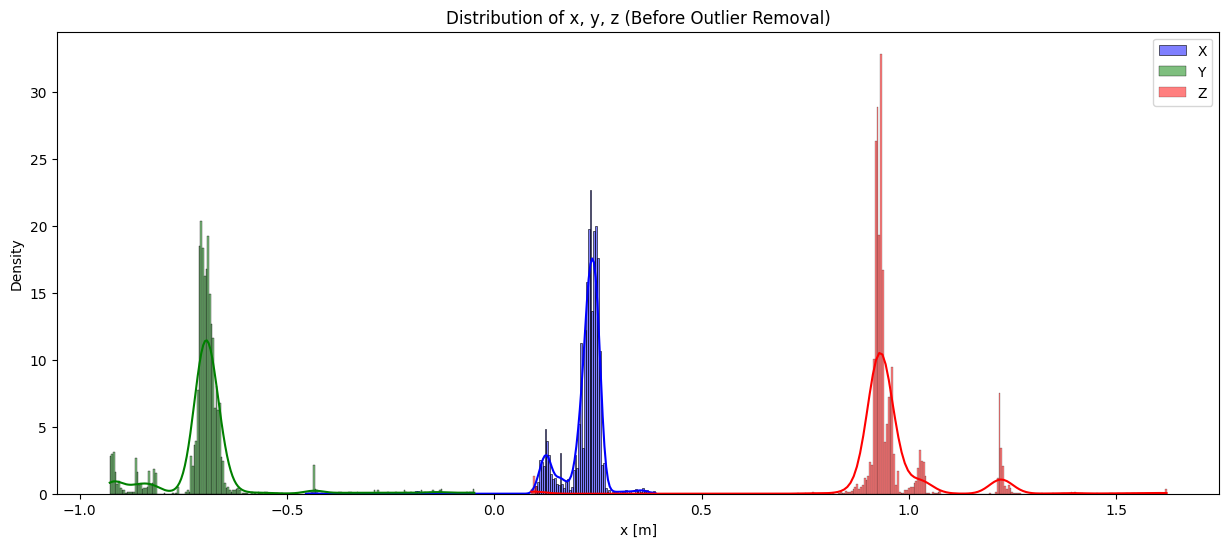

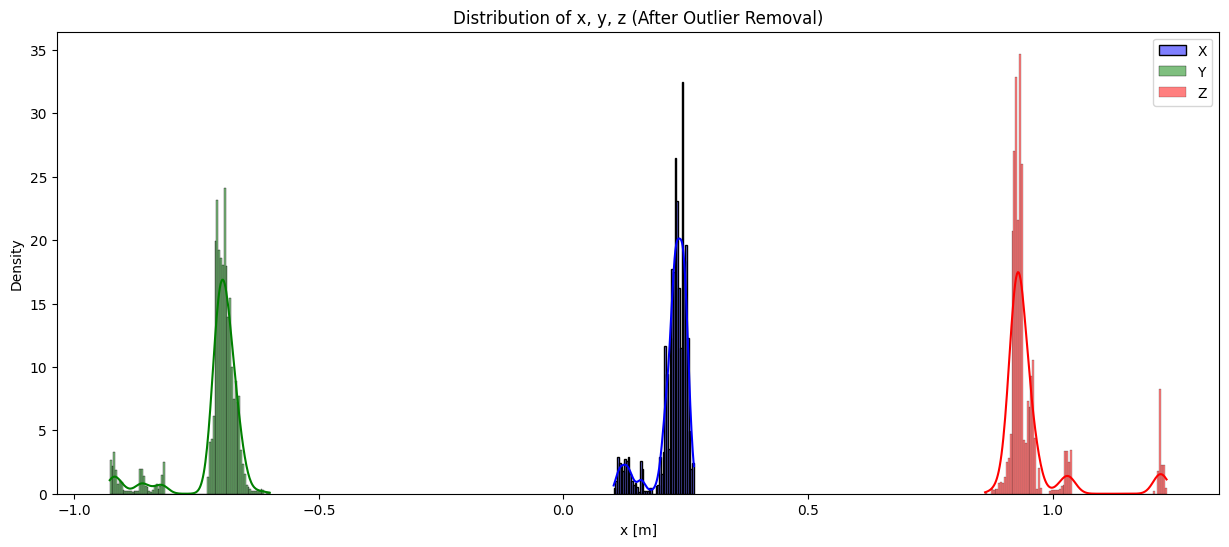

Number of outliers removed: 300 (10.00% of total data)


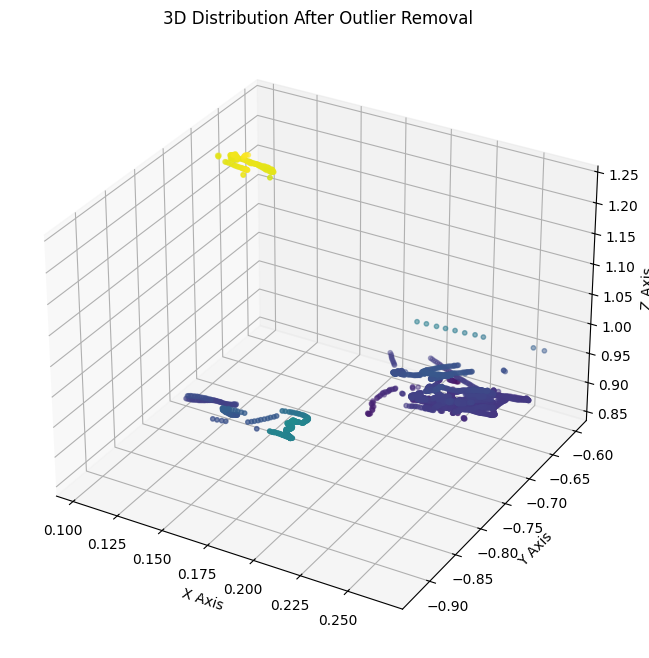

In [ ]:
df_cleaned = remove_outliers_and_plot(df_258, method='IsolationForest', threshold=0.1)
plot_3d_distribution(df_cleaned, title="3D Distribution After Outlier Removal")


# Data Metrics Investigation

In [ ]:
for i in range(1, 8):
    print('-' * 60, f"user0{i}", '-' * 60)

    key = (f'user0{i}', 'walking_holding_a_tray', 'smartwatch')

    try:
        # Retrieve user data from the dictionary
        user_data = user_activity_sensor_dict[key]

        # Combine data from CSV files
        combined_df = read_and_combine_data_from_dict(user_data, directory_path)

        # Skip if no valid data found
        if combined_df.empty:
            print(f"No data found for user0{i}. Skipping...")
            continue

        # Generate statistics (including circular)
        stats_df = generate_statistics(combined_df)

        # Print the circular and linear statistics
        print(stats_df)

        # Plot the data
        plot_distributions(combined_df)

    except KeyError:
        print(f"Key {key} not found. Skipping to the next user.")
    except Exception as e:
        print(f"An error occurred for user0{i}: {e}")


In [ ]:
for i in range(1, 8):
    print('-' * 20, f"user0{i}", '-' * 20)

    key = (f'user0{i}', 'walking_holding_a_tray', 'smartwatch')

    try:
        user_data = user_activity_sensor_dict[key]

        combined_df = read_and_combine_data_from_dict(user_data, directory_path)
        plot_distributions(combined_df)

    except KeyError:
        print(f"Key {key} not found. Skipping to the next user.")


In [ ]:
for i in range(1, 8):
    print('-' * 60, f"user0{i}", '-' * 60)

    key = (f'user0{i}', 'walking_holding_a_tray', 'vicon')

    try:
        user_data = user_activity_sensor_dict[key]

        combined_df = read_and_combine_data_from_dict(user_data, directory_path)
        plot_distributions(combined_df)


    except KeyError:
        print(f"Key {key} not found. Skipping to the next user.")


In [ ]:
for i in range(1, 8):
    print('-' * 60, f"user0{i}", '-' * 60)

    key = (f'user0{i}', 'idle', 'vicon')

    try:
        user_data = user_activity_sensor_dict[key]

        combined_df = read_and_combine_data_from_dict(user_data, directory_path)

        plot_3d_distribution(combined_df)

    except KeyError:
        print(f"Key {key} not found. Skipping to the next user.")

In [ ]:
for i in range(1, 8):
    print('-' * 60, f"user0{i}", '-' * 60)

    key = (f'user0{i}', 'preparing_sandwich', 'vicon')

    try:
        user_data = user_activity_sensor_dict[key]

        combined_df = read_and_combine_data_from_dict(user_data, directory_path)

        plot_3d_distribution(combined_df)

    except KeyError:
        print(f"Key {key} not found. Skipping to the next user.")

In [ ]:
for i in range(1, 8):
    print('-' * 60, f"user0{i}", '-' * 60)

    key = (f'user0{i}', 'walking_holding_a_tray', 'smartwatch')

    try:
        user_data = user_activity_sensor_dict[key]

        combined_df = read_and_combine_data_from_dict(user_data, directory_path)

        print(generate_statistics(combined_df))
    except KeyError:
        print(f"Key {key} not found. Skipping to the next user.")

# Generate Statistics Table for Combinations Between Activity and Sensor


In [ ]:
activ_list = ['stairs_up','walking_with_hands_in_pockets','walking_freely', 'using_phone', 'reading_book', 'idle', 'walking_with_object_underarm', 'washing_mug', 'walking_holding_a_tray', 'washing_face_and_hands', 'walking_with_handbag', 'washing_plate', 'using_remote_control', 'typing', 'preparing_sandwich', 'writing', 'stairs_down', 'brushing_teeth']
sinsor_list = ['smartwatch', 'vicon']
i = 1
def tavl_stas(activ_list,sinsor_list):
  df_stas = pd.DataFrame(columns=['Column', 'Mean', 'Standard Deviation', 'Maximum', 'Minimum', 'Median', 'Range', 'Variance', 'Unique Values', 'Axis', 'Measurement_Type'])
  for h in activ_list:
    if len(sinsor_list) == 1 :
      y = sinsor_list[0]
      key = (f'user0{i}',h, y)
      df_key=generate_statistics_table(user_activity_sensor_dict,key, directory_path, user_range=range(1, 9))
      df_stas = pd.concat([df_stas, df_key], ignore_index=True)
    else:
      for y in sinsor_list:
        key = (f'user0{i}',h, y)
        df_key=generate_statistics_table(user_activity_sensor_dict,key, directory_path, user_range=range(1, 9))
        df_stas = pd.concat([df_stas, df_key], ignore_index=True)
  return df_stas
df_t = tavl_stas(activ_list,sinsor_list)
df_t['Column'] = df_t['Column'].apply(ast.literal_eval)
df_t[['User', 'Activity', 'Sensor']] = pd.DataFrame(df_t['Column'].to_list(), index=df_t.index)


In [ ]:
df_t_vicon = df_t[df_t['Sensor'] == 'vicon']
df_t_smartwatch = df_t[df_t['Sensor'] == 'smartwatch']

#Examination of Statistical Table Columns

## Maximum and minimum of each activity

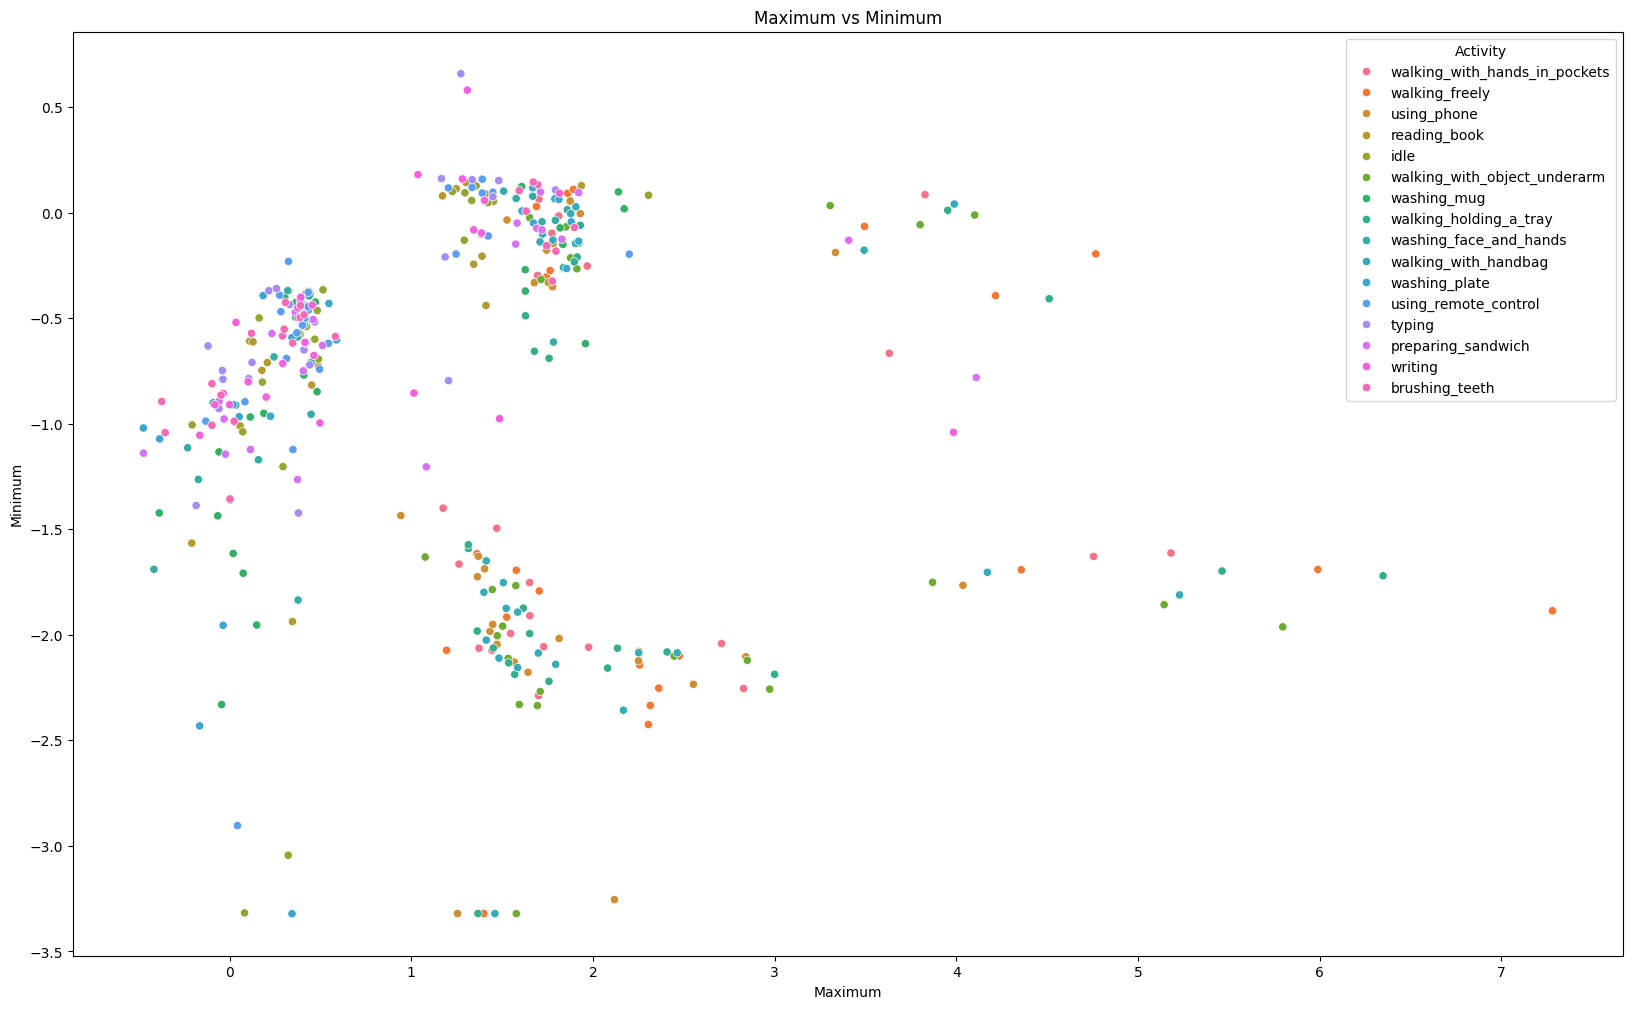

In [ ]:
plt.figure(figsize=(20, 12))
sns.scatterplot(data=df_t_vicon, x='Maximum', y='Minimum', hue='Activity')
plt.title("Maximum vs Minimum")
plt.show()

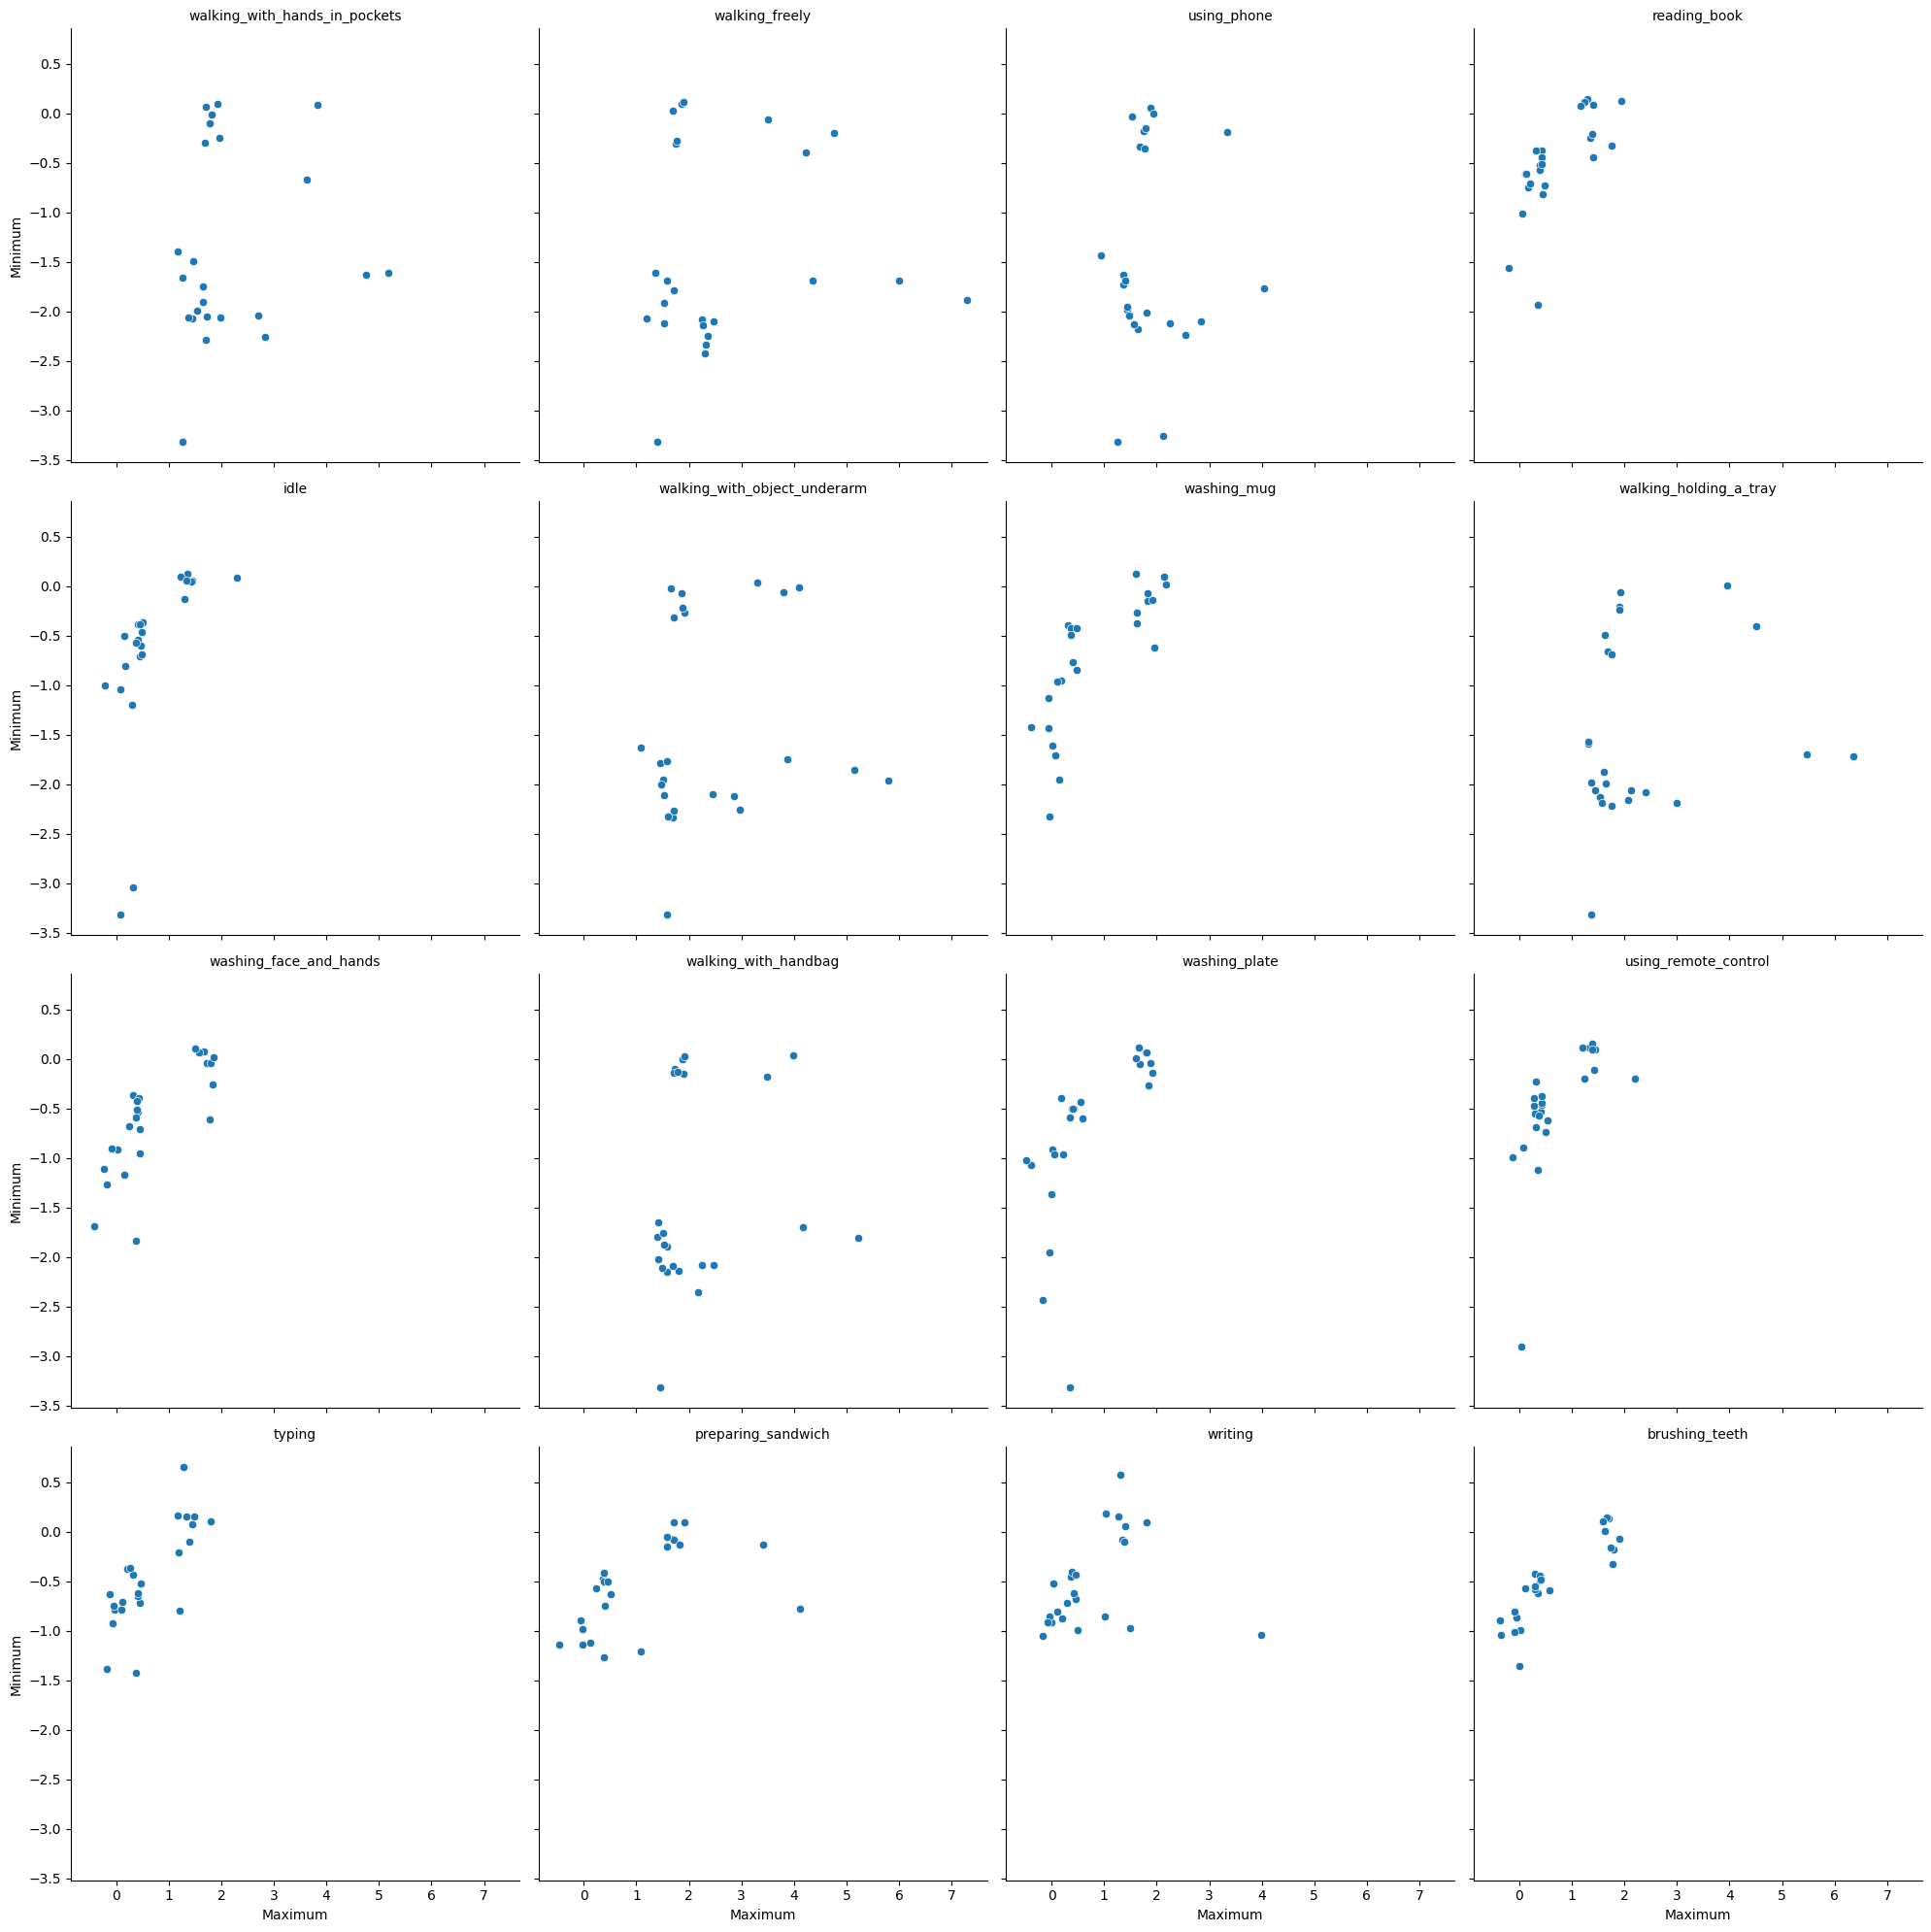

In [ ]:
g = sns.FacetGrid(df_t_vicon, col='Activity', col_wrap=4, height=5)
g.map(sns.scatterplot, 'Maximum', 'Minimum')

g.set_titles("{col_name}")

plt.show()


In [ ]:
df_t.columns

Index(['Column', 'Mean', 'Standard Deviation', 'Maximum', 'Minimum', 'Median',
       'Range', 'Variance', 'Unique Values', 'Axis', 'Measurement_Type',
       'User', 'Activity', 'Sensor'],
      dtype='object')

## Unique values

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


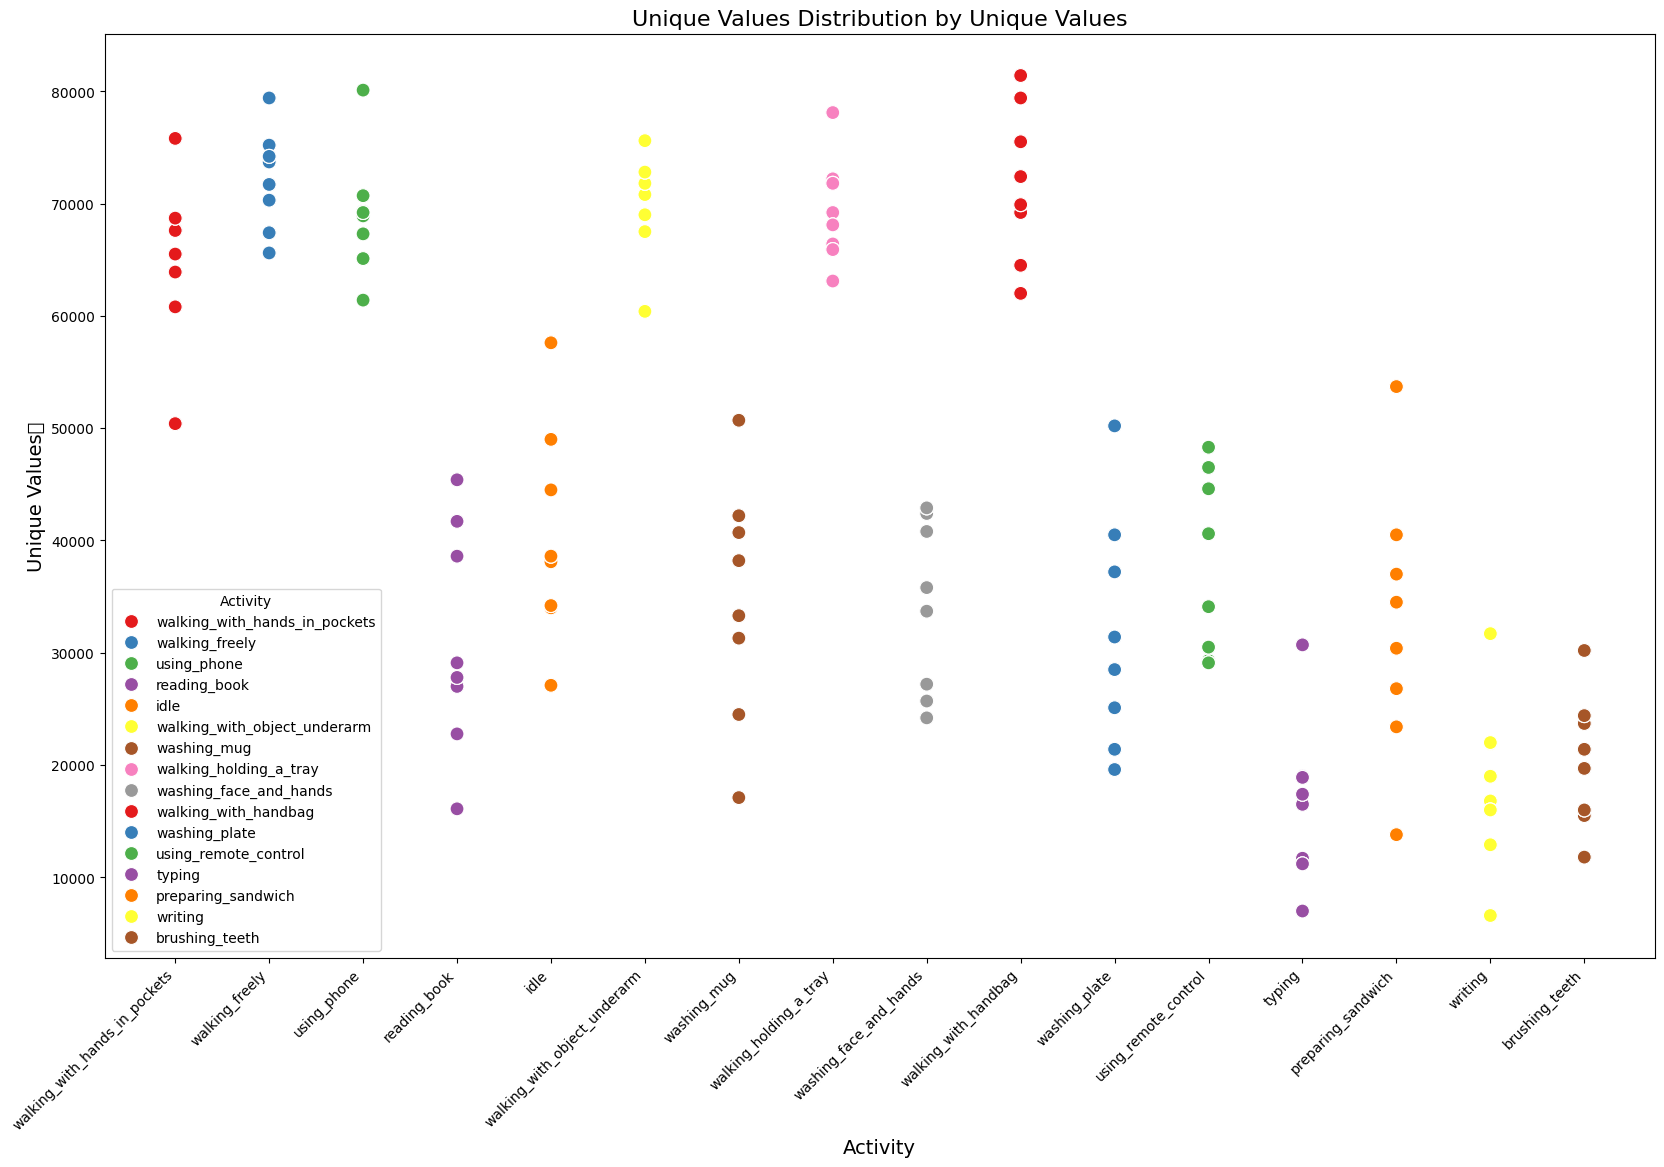

In [ ]:
plt.figure(figsize=(20, 12))
sns.scatterplot(data=df_t_vicon, x='Activity', y='Unique Values', hue='Activity', palette='Set1', s=100)

plt.title("Unique Values Distribution by Unique Values", fontsize=16)
plt.xlabel('Activity', fontsize=14)
plt.ylabel('Unique Values	', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Activity')

plt.show()

## Outlier Detection

In [ ]:
# Model setting
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_t['anomaly'] = iso_forest.fit_predict(df_t[['Mean', 'Standard Deviation', 'Maximum', 'Minimum']])

# Outliers checking
outliers = df_t[df_t['anomaly'] == -1]
print("Number of outliers:", len(outliers))


Number of outliers: 82


In [ ]:
outliers

,Column,Mean,Standard Deviation,Maximum,Minimum,Median,Range,Variance,Unique Values,Axis,Measurement_Type,User,Activity,Sensor,anomaly
6,"(user01, stairs_up, smartwatch)",-28.66141,52.048426,228.1095,-236.924,-25.925001,465.0335,2709.038698,1672,x,magnetometer [uT],user01,stairs_up,smartwatch,-1
7,"(user01, stairs_up, smartwatch)",15.457924,35.066026,215.1165,-167.689,9.7905,382.8055,1229.626171,1906,y,magnetometer [uT],user01,stairs_up,smartwatch,-1
8,"(user01, stairs_up, smartwatch)",-1.256179,27.005332,322.202,-252.54001,-0.61,574.74201,729.28798,2118,z,magnetometer [uT],user01,stairs_up,smartwatch,-1
17,"(user02, stairs_up, smartwatch)",-8.260882,8.560656,6.8015,-64.294,-6.649,71.0955,73.284832,103,z,magnetometer [uT],user02,stairs_up,smartwatch,-1
18,"(user04, stairs_up, smartwatch)",11.146992,6.924994,53.924,1.1895,9.394,52.7345,47.955548,71,x,magnetometer [uT],user04,stairs_up,smartwatch,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,"(user06, stairs_down, smartwatch)",147.017253,8.394143,160.3385,111.6605,148.5045,48.678,70.46163,61,z,magnetometer [uT],user06,stairs_down,smartwatch,-1
1535,"(user01, brushing_teeth, smartwatch)",-9.451438,18.378486,57.4925,-52.3075,-4.819,109.8,337.768751,248,z,magnetometer [uT],user01,brushing_teeth,smartwatch,-1
1578,"(user06, brushing_teeth, smartwatch)",23.119029,31.349932,53.8935,-61.030502,34.5565,114.924002,982.818259,354,x,magnetometer [uT],user06,brushing_teeth,smartwatch,-1
1580,"(user06, brushing_teeth, smartwatch)",-10.237044,15.445377,19.093,-64.9345,-4.758,84.0275,238.55968,248,z,magnetometer [uT],user06,brushing_teeth,smartwatch,-1


In [ ]:
outliers_grouped = df_t[df_t['anomaly'] == -1]
outliers_grouped_summary = outliers_grouped.groupby(['Activity', 'Sensor']).size().reset_index(name='Outliers Count')

print("Outliers by Activity and Sensor:")
print(outliers_grouped_summary)


Outliers by Activity and Sensor:
                        Activity      Sensor  Outliers Count
0                 brushing_teeth  smartwatch               4
1                           idle  smartwatch               6
2             preparing_sandwich  smartwatch               4
3                   reading_book  smartwatch               3
4                    stairs_down  smartwatch              11
5                      stairs_up  smartwatch               9
6                         typing  smartwatch               8
7           using_remote_control  smartwatch               4
8                 walking_freely  smartwatch               1
9         walking_holding_a_tray  smartwatch               1
10          walking_with_handbag  smartwatch               2
11  walking_with_object_underarm  smartwatch               5
12        washing_face_and_hands  smartwatch               8
13                   washing_mug  smartwatch               1
14                 washing_plate  smartwatch        

In [ ]:
print("\nDetailed Outliers:")
print(outliers_grouped[['User', 'Activity', 'Sensor', 'Mean', 'Standard Deviation', 'Maximum', 'Minimum', 'anomaly']])


Detailed Outliers:
        User        Activity      Sensor        Mean Standard Deviation  \
6     user01       stairs_up  smartwatch   -28.66141          52.048426   
7     user01       stairs_up  smartwatch   15.457924          35.066026   
8     user01       stairs_up  smartwatch   -1.256179          27.005332   
17    user02       stairs_up  smartwatch   -8.260882           8.560656   
18    user04       stairs_up  smartwatch   11.146992           6.924994   
...      ...             ...         ...         ...                ...   
1162  user06     stairs_down  smartwatch  -15.588962           5.708084   
1163  user06     stairs_down  smartwatch  147.017253           8.394143   
1218  user06  brushing_teeth  smartwatch   23.119029          31.349932   
1220  user06  brushing_teeth  smartwatch  -10.237044          15.445377   
1228  user07  brushing_teeth  smartwatch   27.494653          19.456959   

       Maximum    Minimum  anomaly  
6     228.1095   -236.924       -1  
7    

In [ ]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)

df_t['anomaly'] = iso_forest.fit_predict(df_t[['Mean', 'Standard Deviation', 'Maximum', 'Minimum']])

outliers_grouped = pd.DataFrame()

for (user, activity, sensor), group in df_t.groupby(['User', 'Activity', 'Sensor']):
    group['anomaly'] = iso_forest.fit_predict(group[['Mean', 'Standard Deviation', 'Maximum', 'Minimum']])

    outliers_grouped = pd.concat([outliers_grouped, group[group['anomaly'] == -1]])

outliers_summary = outliers_grouped.groupby(['User', 'Activity', 'Sensor']).size().reset_index(name='Outliers Count')

print("Outliers Summary by User, Activity, and Sensor:")
print(outliers_summary)

print("\nDetailed Outliers:")
print(outliers_grouped[['User', 'Activity', 'Sensor', 'Mean', 'Standard Deviation', 'Maximum', 'Minimum', 'anomaly']])


Outliers Summary by User, Activity, and Sensor:
       User                      Activity      Sensor  Outliers Count
0    user01                brushing_teeth  smartwatch               1
1    user01                          idle  smartwatch               1
2    user01            preparing_sandwich  smartwatch               1
3    user01                  reading_book  smartwatch               1
4    user01                   stairs_down  smartwatch               1
..      ...                           ...         ...             ...
132  user08  walking_with_object_underarm  smartwatch               1
133  user08        washing_face_and_hands  smartwatch               1
134  user08                   washing_mug  smartwatch               1
135  user08                 washing_plate  smartwatch               1
136  user08                       writing  smartwatch               1

[137 rows x 4 columns]

Detailed Outliers:
        User                      Activity      Sensor       Mean  \

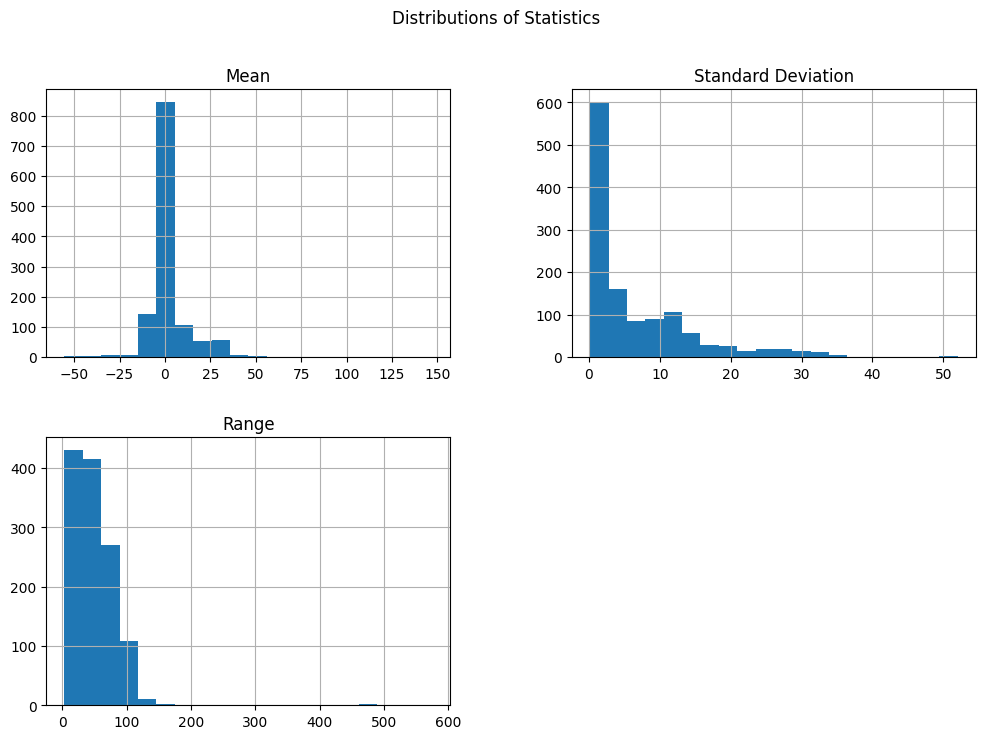

In [ ]:
# Selecting statistical columns for visualization
columns_to_plot = ['Mean', 'Standard Deviation', 'Range']

# Converting columns to numeric if they are not already
for col in columns_to_plot:
    if df_t[col].dtype == 'object':
        df_t[col] = pd.to_numeric(df_t[col], errors='coerce')

# Create a histogram for each column
df_t[columns_to_plot].hist(bins=20, figsize=(12, 8))
plt.suptitle("Distributions of Statistics")
plt.show()


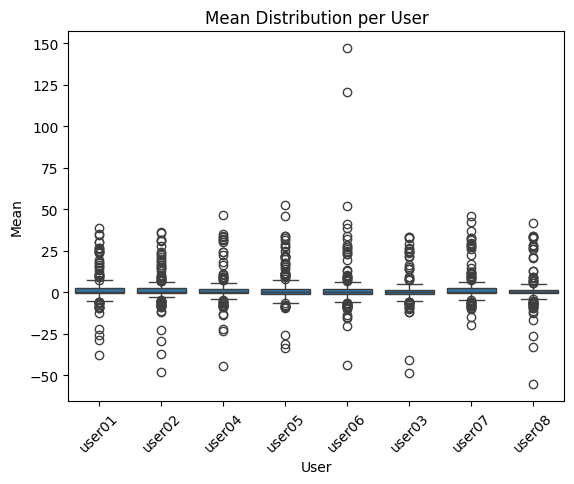

In [ ]:
# Boxplot by user
sns.boxplot(data=df_t, x='User', y='Mean')
plt.title("Mean Distribution per User")
plt.xticks(rotation=45)
plt.show()


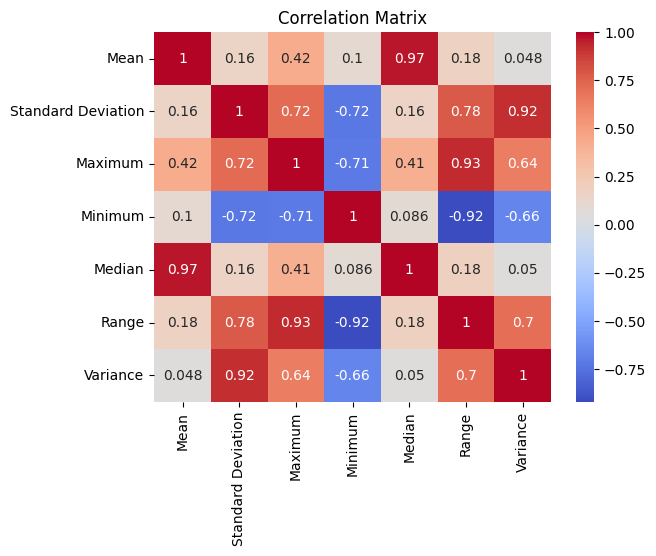

In [ ]:
# Calculating correlations
corr_matrix = df_t[['Mean', 'Standard Deviation', 'Maximum', 'Minimum', 'Median', 'Range', 'Variance']].corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


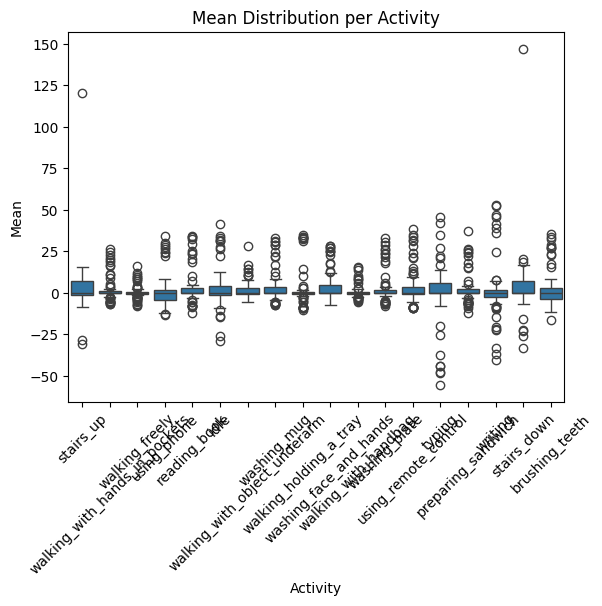

In [ ]:
# Distribution of Mean per Activity
sns.boxplot(data=df_t, x='Activity', y='Mean')
plt.title("Mean Distribution per Activity")
plt.xticks(rotation=45)
plt.show()


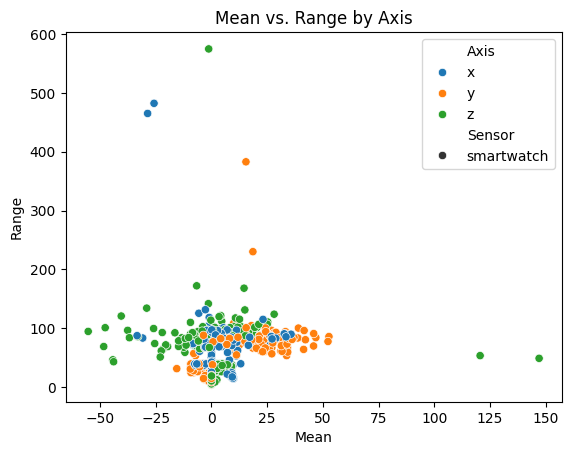

In [ ]:
# Scatterplot by axis (Axis)
sns.scatterplot(data=df_t, x='Mean', y='Range', hue='Axis', style='Sensor')
plt.title("Mean vs. Range by Axis")
plt.show()


In [ ]:
# Grouping the DataFrame by 'Activity' and 'Axis'
activities = df_t['Activity'].unique()
axes = df_t['Axis'].unique()

# Create histograms for each activity and axis
for activity in activities:
    for axis in axes:
        # Filter data for the current activity and axis
        activity_axis_data = df_t[(df_t['Activity'] == activity) & (df_t['Axis'] == axis)]

        if not activity_axis_data.empty:
            # Creating histograms for the numeric columns of interest
            activity_axis_data[columns_to_plot].hist(bins=20, figsize=(12, 8))
            plt.suptitle(f"Distributions of Statistics for Activity: {activity}, Axis: {axis}")
            plt.show()



In [ ]:
df_t['Column'] = df_t['Column'].apply(ast.literal_eval)
df_t[['User', 'Activity', 'Sensor']] = pd.DataFrame(df_t['Column'].to_list(), index=df_t.index)

In [ ]:
df_t['Combined'] = df_t[['Activity', 'Measurement_Type']].apply(
    lambda row: f"{row['Activity']}_{row['Measurement_Type']}", axis=1
)

grouped_1 = df_t.groupby('Combined').agg({'Measurement_Type':'first' ,'Mean': 'mean',
                    'Standard Deviation': 'std',
                    'Maximum': 'max',
                    'Minimum': 'min',
                    'Median': 'median',
                    'Range': 'first',
                    'Variance': 'first',
                    'Unique Values': 'first',
                    'Axis': 'first'}).reset_index()
# grouped_1

# Iterates over all Measurement_Type types
for measurement_type in df_t['Measurement_Type'].unique():
    # Filter the data for each Measurement_Type
    filtered_data = df_t[df_t['Measurement_Type'] == measurement_type]

    # Grouping by Combined and calculating averages and standard deviation
    grouped = filtered_data.groupby('Combined').agg({
        'Mean': 'mean',
        'Standard Deviation': 'mean',
        'Maximum': 'max',
        'Minimum': 'min',
        'Median': 'median',
        'Range': lambda x: x.max() - x.min(),
        'Variance': 'var',
        'Unique Values': lambda x: len(x.unique())
    }).reset_index()

    # scatterplot (Mean)
    plt.figure(figsize=(14, 8))
    sns.scatterplot(data=grouped, x='Combined', y='Mean', palette='coolwarm', s=100, edgecolor='black', marker='o')
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.title(f'Average Mean by Combined Categories ({measurement_type})', fontsize=18, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # lineplot (Standard Deviation)
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=grouped, x='Combined', y='Standard Deviation', marker='o', linewidth=2, color='darkblue', label='Standard Deviation')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.title(f'Standard Deviation by Combined Categories ({measurement_type})', fontsize=16, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=12)
    plt.ylabel('Standard Deviation', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # barplot (Maximum vs Minimum)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped, x='Combined', y='Minimum', color='lightblue', label='Minimum', edgecolor='black')
    sns.barplot(data=grouped, x='Combined', y='Maximum', color='darkblue', label='Maximum', edgecolor='black')

    plt.title(f'Minimum and Maximum for Each Combined Category ({measurement_type})', fontsize=16, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.legend(title='Value Type', fontsize=12, title_fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # barplot (Median)
    plt.figure(figsize=(14, 8))
    sns.barplot(data=grouped, x='Combined', y='Median', palette='coolwarm', edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.title(f'Median Value by Combined Categories ({measurement_type})', fontsize=18, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Median Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # barplot (Range)
    plt.figure(figsize=(14, 8))
    sns.barplot(data=grouped, x='Combined', y='Range', palette='viridis', edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.title(f'Range (Max - Min) by Combined Categories ({measurement_type})', fontsize=18, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Range', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # barplot (Variance)
    plt.figure(figsize=(14, 8))
    sns.barplot(data=grouped, x='Combined', y='Variance', palette='plasma', edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.title(f'Variance by Combined Categories ({measurement_type})', fontsize=18, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Variance', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # barplot (Unique Values)
    plt.figure(figsize=(14, 8))
    sns.barplot(data=grouped, x='Combined', y='Unique Values', palette='cividis', edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.title(f'Unique Values by Combined Categories ({measurement_type})', fontsize=18, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Unique Values Count', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to add values ​​inside the bar
def add_value_labels(ax, spacing=5):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', fontweight='bold',
                    xytext=(0, spacing), textcoords='offset points')

# Iterates over all Measurement_Type types
for measurement_type in df_t['Measurement_Type'].unique():
# Filter the data for each Measurement_Type
    filtered_data = df_t[df_t['Measurement_Type'] == measurement_type]

# Grouping by Combined and calculating averages and standard deviation
    grouped = filtered_data.groupby('Combined').agg({
        'Mean': 'mean',
        'Standard Deviation': 'mean',
        'Maximum': 'max',
        'Minimum': 'min',
        'Median': 'median',
        'Range': lambda x: x.max() - x.min(),
        'Variance': 'var',
        'Unique Values': lambda x: len(x.unique())
    }).reset_index()

# 1. Barplot Upgrade (Mean)
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=grouped, x='Combined', y='Mean', palette='coolwarm', edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.title(f'Average Mean by Combined Categories ({measurement_type})', fontsize=18, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    add_value_labels(ax)
    plt.tight_layout()
    plt.show()

    # 2. lineplot Upgrade (Standard Deviation)
    plt.figure(figsize=(14, 8))
    ax = sns.lineplot(data=grouped, x='Combined', y='Standard Deviation', marker='o', linewidth=2, color='darkblue', label='Standard Deviation')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.title(f'Standard Deviation by Combined Categories ({measurement_type})', fontsize=16, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=12)
    plt.ylabel('Standard Deviation', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 3. Barplot Upgrade (Maximum vs Minimum)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=grouped, x='Combined', y='Minimum', color='lightblue', label='Minimum', edgecolor='black')
    sns.barplot(data=grouped, x='Combined', y='Maximum', color='darkblue', label='Maximum', edgecolor='black')

    plt.title(f'Minimum and Maximum for Each Combined Category ({measurement_type})', fontsize=16, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.legend(title='Value Type', fontsize=12, title_fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 4. Heatmap upgrade (Mean Value Heatmap)
    plt.figure(figsize=(14, 8))
    heatmap_data = grouped.pivot("Combined", "Measurement_Type", "Mean")
    sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt='.2f', linewidths=1)
    plt.title(f'Mean Value Heatmap by Combined Categories and Measurement Type', fontsize=18, fontweight='bold')
    plt.xlabel('Measurement Type', fontsize=14)
    plt.ylabel('Combined Categories', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 5. Boxplot upgrade (Distribution of Mean)
    plt.figure(figsize=(14, 8))
    ax = sns.boxplot(data=grouped, x='Combined', y='Mean', palette='coolwarm')
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.title(f'Distribution of Mean by Combined Categories ({measurement_type})', fontsize=18, fontweight='bold')
    plt.xlabel('Combined Activity-Sensor-Measurement Type', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 6.Scatterplot upgrade (Maximum vs Minimum with Annotations)
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(data=grouped, x='Minimum', y='Maximum', hue='Combined', palette='tab20', s=150, alpha=0.8, edgecolor='black')

    plt.title(f'Maximum vs Minimum for Each Combined Category ({measurement_type})', fontsize=16, fontweight='bold')
    plt.xlabel('Minimum Value', fontsize=14)
    plt.ylabel('Maximum Value', fontsize=14)
    plt.legend(title='Combined Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [ ]:
grouped_2 = grouped_1.groupby('Measurement_Type').agg({
    'Mean': 'mean',
    'Standard Deviation': 'mean',
    'Maximum': 'max',
    'Minimum': 'min'})

# Experiments

##PCA

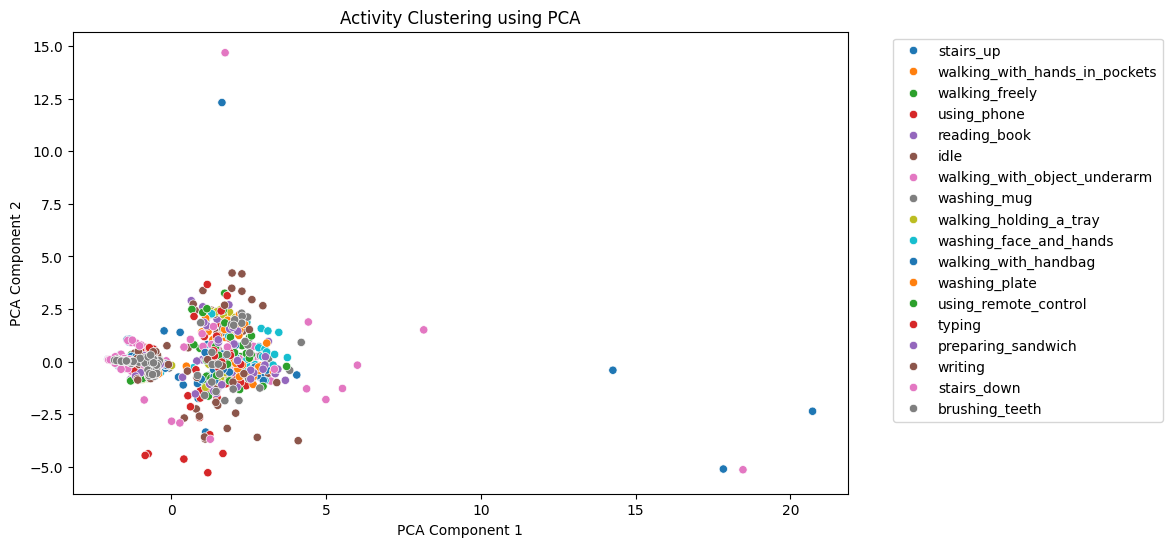

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_t['Activity'], palette='tab10')
plt.title('Activity Clustering using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


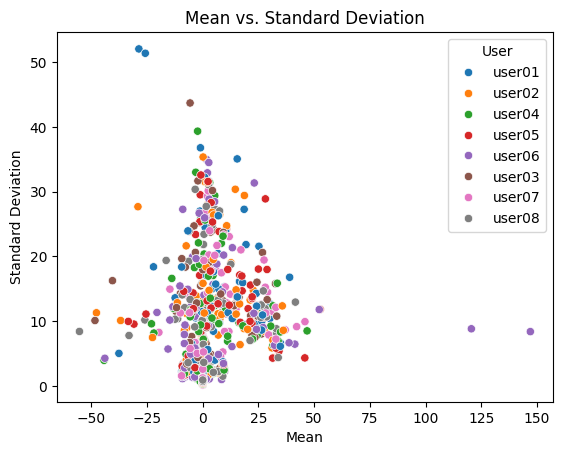

In [ ]:
sns.scatterplot(data=df_t, x='Mean', y='Standard Deviation', hue='User')
plt.title("Mean vs. Standard Deviation")
plt.show()

In [ ]:
def perform_pca(data, n_components=3):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance}")
    return pca_result

directory_path = "/content/i_cant_see/unlabeled/unlabeled"
combined_data = read_and_combine_data_from_dict(activity_sensor_bodypart_side_dict, directory_path)
preprocessed_data = preprocess_data(combined_data)
pca_result = perform_pca(preprocessed_data)

# Visualization of the PCA
def plot_pca_3d(pca_result):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=pca_result[:, 2], cmap='viridis', s=10)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('3D Visualization of PCA')
    plt.show()

plot_pca_3d(pca_result)


###KNN

In [ ]:
def perform_kmeans(data, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    return clusters

clusters = perform_kmeans(preprocessed_data, n_clusters=5)

# Visualization of the clusters
def plot_clusters_3d(data, clusters):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=clusters, cmap='viridis', s=10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Clustering Visualization (K-Means)')
    plt.show()

plot_clusters_3d(preprocessed_data.values, clusters)


# Outliers

In [ ]:
# Function to read data
def combine_data_by_key(data_dict, directory_path):
    combined_dict = {}
    for key, df in data_dict.items():
        all_data = []
        for idx, row in df.iterrows():
            file_id = row['id']
            file_name = f"{file_id}.csv"
            file_path = os.path.join(directory_path, file_name)
            if os.path.exists(file_path):
                df_file = pd.read_csv(file_path)
                df_file['id'] = file_id
                all_data.append(df_file)

        if all_data:
            combined_dict[key] = pd.concat(all_data, ignore_index=True)

    return combined_dict

# Pre-processing function (normalization and cleaning)
def preprocess_data(df, cols=['x [m]', 'y [m]', 'z [m]']):
    # Keep only the relevant columns
    data = df[cols].dropna()
    # Data normalization
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return pd.DataFrame(normalized_data, columns=cols)


In [ ]:
def perform_dbscan(data, eps=0.5, min_samples=10):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    return clusters

dbscan_clusters = perform_dbscan(preprocessed_data, eps=0.2, min_samples=5)

# Visualization of the clusters
plot_clusters_3d(preprocessed_data.values, dbscan_clusters)


In [ ]:
def detect_outliers(dbscan_clusters):
    outliers = preprocessed_data[dbscan_clusters == -1]
    print(f"Number of outliers detected: {len(outliers)}")
    return outliers

# Outliers detection
outliers = detect_outliers(dbscan_clusters)


In [ ]:
# Loading the data
data = df_61641

# Isolation Forest
clf = IsolationForest(contamination=0.01)
clf.fit(data)
predictions = clf.predict(data)

# anomaly detection
data['anomaly'] = predictions
data[data['anomaly'] == -1]

In [ ]:
def detect_outliers_by_sensor(data_dict, directory_path, contamination=0.05):
    """
      Identifies outliers for each DataFrame in the dictionary, given the sensor type and the various metrics.

      Parameters:
      - data_dict: A dictionary where the keys are combinations and the values ​​are DataFrames.
      - directory_path: Path to the data directory.
      - contamination: The estimated outlier ratio (default: 0.05).

      Returns:
      A new dictionary where each DataFrame includes an 'outlier' column with the model results.
    """
    processed_dict = {}

    for key, df in data_dict.items():
        print(f"Processing key: {key}")
        user, activity, sensor, body_part, side, sequence = key  # Dividing the combinations
        print(sensor)

        # Reading data from files
        combined_data = read_and_combine_data_from_dict({key: df}, directory_path)  # Update to read the correct DataFrame

        # Identify features by sensor type
        if sensor == 'smartwatch':  # Sensor with 3 indices (x, y, z) for each index
            features = []
            for metric in ['Gyroscope [rad/s]', 'Acceleration [m/s²]', 'Magnetometer [μT]']:
                features.extend([f'{metric}_x', f'{metric}_y', f'{metric}_z'])

        elif sensor == 'vicon':
            features = ['x [m]', 'y [m]', 'z [m]']

        else:
            print(f"Unknown sensor type for key {key}. Skipping...")
            continue

        # Check if the features exist
        if not set(features).issubset(df.columns):
            print(f"Skipping key {key}: Missing required columns {features}")
            continue

        # IsolationForest
        data = df[features].dropna()  # Preserving relevant features and taking rows without missing data
        model = IsolationForest(contamination=contamination, random_state=42)
        df['outlier'] = -1
        if not data.empty:
            predictions = model.fit_predict(data)
            df.loc[data.index, 'outlier'] = predictions

        processed_dict[key] = df

    return processed_dict

